In [1]:
from data.data import Unitig, Sequence, Kmer
import pickle
import os
import json
from graph.graph import add_to_dict, get_kmer_count_from_sequences, get_gt_graph, get_unitigs_bcalm, Graph, switch_index
from data.inout import load_sequences,create_gfa_csv
from common.utils import numseq2bytes, seq2num, compute_unitig_ref
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [4]:
ref_file = "../input/truth_data/GCA_027944875.1_ASM2794487v1_genomic.truth_genes.json"
with open(ref_file, 'r') as f:
    ref_data = json.load(f)
# read_file = "../input/real_data/SRR23044204_1.subset.pandora_gene_calls.json"
# with open(read_file, 'r') as f:
#     read_data = json.load(f)

blocks2reads = {}
for k,g in read_data.items():
    for block in g:
        add_to_dict(blocks2reads,block[1:],k)
for k,g in ref_data.items():
    for block in g:
        add_to_dict(blocks2reads,block[1:],k)
blocks = list(blocks2reads.keys())
blocks.sort()

alphabet = [("+"+p1,"-"+p1) for p1 in blocks]
bi_alphabet = (alphabet,{k:((i+1)*((-1)**j)) for i, ks in enumerate(alphabet) for j, k in enumerate(ks)})
l_alphabet = len(alphabet)
if l_alphabet < 2**7:
    Sequence.n_b = 1
elif l_alphabet < 2**15:
    Sequence.n_b = 2
elif l_alphabet < 2**31:
    Sequence.n_b = 4
else:
    Sequence.n_b = 8
Sequence.bi_alphabet = bi_alphabet

ref_seqs = [Sequence(i,numseq2bytes(seq2num(seq,Sequence.bi_alphabet),Sequence.n_b),1) for i,seq in enumerate(ref_data.values())]
read_data_trimmed = read_data.values()
read_seqs = [Sequence(i, numseq2bytes(seq2num(seq,Sequence.bi_alphabet), Sequence.n_b), 1) for i,seq in enumerate(read_data_trimmed)]

with open('reads.npy', 'wb') as f:
    np.save(f,np.array([seq.seq for seq in read_seqs],dtype=object))
b= {}
for i, (p1,p2) in enumerate(alphabet):
    b[i+1]= p1
    b[-(i+1)]=p2
j = json.dumps(b)

with open('blocks.json', 'w') as f:
    f.write(j)

subseq = read_seqs[:]
prev_unitigs = []

n_clip = 5
RES_OUTPUT_FOLDER = "../res/ecoli_bcalm/real_data/"
kmin, kmax = 23,23
k=23
filename = os.path.join(RES_OUTPUT_FOLDER,"res_unitigs_max_unitigs_reads_clippedTEST_k_{}_{}.pkl".format(kmin,kmax))
unitigs = load_sequences(filename)
# unitigs = Graph()
print(len(unitigs))


631


In [5]:
a = compute_unitig_ref(read_seqs,ref_seqs)
a_a = np.array(a[1])
a_l = list(a_a.argmax(axis=0))
a_n = [a_l.count(k) for k in range(3)]

KeyboardInterrupt: 

In [4]:
# def add_unitigs_sets(unitigs,sets,key = None):
#     for u in unitigs:
#         if key is None:
#             for key in range(len(sets)):
#                 if u in sets[key]:
#                     sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
#                     sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)
#                     break
#             sets.append(set())
#             key = len(sets)-1
#             sets[key].add(u)
#             sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
#             sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)

#         else:
#             if u not in sets[key]:
#                 sets[key].add(u)
#                 sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
#                 sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)
#     return sets
        


In [5]:
def add_unitigs_sets(unitigs,sets,key):
    for u in unitigs:
        if u not in sets[key]:
            sets[key][u]=u
            sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
            sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)
    return sets

In [6]:
sets = []
for u in unitigs:
    found = False
    for key in range(len(sets)):
        if u in sets[key]:
            found=True
            break
    if not found:
        sets.append(Graph())
        key = len(sets)-1
        sets[key][u]=u
        sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
        sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)

In [7]:
sets = [s for s in sets if len(s)>1]
sets.sort(key = len)

In [8]:
[len(s) for s in sets]

[7, 23, 136]

In [9]:
chromosome = sets[-1]

In [10]:
starts=[]
for u in chromosome:
    l1,l2 = len(u.link[0]) , len(u.link[1])
    if l1*l2==0 and l1+l2!=0:
        starts.append(u)
print(len(starts))

2


In [11]:
def add_coordinate(s, mode, coordinates,c, k):
    if s not in coordinates:
        if all([prev_s in coordinates for prev_s in s.link[switch_index(0,mode)]]):
            if len(s.link[switch_index(0,mode)])==0:
                new_c = c
            else:
                new_c = max([coordinates[prev_s][0][1] - (k-1) for prev_s in s.link[switch_index(0,mode)]])
            coordinates[s]=([new_c,new_c+len(s)],mode)
            # print(s.id)
            # c = c+1
            # for next_s, edge_modes in s.link[switch_index(0,mode)].items():
            #     for edge_mode in edge_modes:
            #         c = max(c, coordinates[next_s][0]+1)
            if s.id in [112,132]:
                print([coordinates[prev_s][0] for prev_s in s.link[switch_index(0,mode)]])
                print(s.id, c, new_c)
            for next_s, edge_modes in s.link[switch_index(1,mode)].items():
                for edge_mode in edge_modes:
                    next_mode = mode*edge_mode
                    coordinates = add_coordinate(next_s, next_mode, coordinates, new_c,k)
            
    return coordinates

In [12]:
start, end = starts[1],starts[0]

coordinates_1 = dict()
coordinates_2 = dict()
s = start
c = 0
k=23

coordinates_1 = add_coordinate(start, 1, coordinates_1,0,k)
coordinates_2 = add_coordinate(end, -1, coordinates_2,0,k)

max_1 = max([x[0][1] for x in coordinates_1.values()])
max_2 = max([x[0][1] for x in coordinates_2.values()])

coordinates_2 = {s:([max_2-x[0][1], max_2-x[0][0]],-x[1]) for s,x in coordinates_2.items()}

print(len(coordinates_1),max_1)
print(len(coordinates_2),max_2)

coordinates = dict()

for s in chromosome:
    coordinates[s] = (np.array(coordinates_1[s][0])+np.array(coordinates_2[s][0]),coordinates_1[s][1])
# for s in chromosome:
#     if coordinates_1[s][0] in [0,67]:
#         print(1,coordinates_1[s][0])
#         print(0,coordinates[s][0])
#         print(str(s))
#     if coordinates_2[s][0] in [0,67]:
#         print(2,coordinates_1[s][0])
#         print(0,coordinates[s][0])
#         print(str(s))
# co2co = list(set([c[0] for c in coordinates.values()]))
# co2co.sort()
# d2co = {e:i for i,e in enumerate(co2co)}
# for s, (c,m) in coordinates.items():
#     coordinates[s] = (d2co[c],m)

[[1530, 1575], [1530, 1574]]
132 1530 1553
[[1685, 1708], [1663, 1706]]
112 1663 1686
[[2124, 2168], [2124, 2169]]
112 2124 2147
[[2199, 2222], [2177, 2220]]
132 2177 2200
136 3885
136 3885


In [13]:
coordinates[end]

(array([7550, 7770]), 1)

In [14]:
max_3 = max([coordinates[s][0][1] for s in chromosome])

In [15]:
import warnings

def sort_by_median(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        m = np.median(np.argwhere(x).flatten())
        if np.isnan(m):
            m=-1
    return m
def get_max_block(x):
    c= 0
    n_c = 0
    new= True
    for xx in x:
        if xx==1:
            if new:
                new=False
            n_c+=1
        else:
            if not new:
                c = max(c,n_c)
                n_c=0
            new = True
    c = max(c,n_c)
    return c
def get_max_block_mean(x):
    c= 0
    n_c = 0
    i_min=0
    n_i_min = 0
    new= True
    for i, xx in enumerate(x):
        if xx==1:
            if new:
                new=False
                n_i_min = i
            n_c+=1
        else:
            if not new:
                if n_c>c:
                    c = n_c
                    i_min = n_i_min
                n_c=0
            new = True
    if n_c>c:
        c = n_c
        i_min = n_i_min
    return i_min+(c-1)/2

In [16]:
get_max_block_mean([0,1,1,0, 0,1,1,1,1,0,0,0])

6.5

In [57]:
l = [len(s)/(coordinates[s][0][1]-coordinates[s][0][0]) for s in chromosome]

In [59]:
print(min(l),max(l))

0.5 0.5


In [132]:
ref_seqs[0].len

3695

In [131]:
a.shape[1]/2

3885.5

(136, 7771)


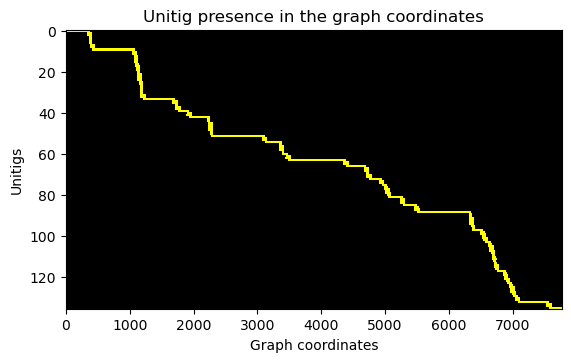

In [138]:

a = np.zeros((len(chromosome),max_3+1))
print(a.shape)
for  i, s in enumerate(chromosome):
    c = coordinates[s][0]
    a[i,c[0]:c[1]]=1
b = list(a)
b.sort(key = sort_by_median)
fig, ax = plt.subplots()
p = plt.imshow(b, cmap= "gnuplot",interpolation='none')
ax.set_aspect(a.shape[1]/a.shape[0]*9/16)
ax.set_ylabel("Unitigs")
ax.set_xlabel("Graph coordinates")
ax.set_title("Unitig presence in the graph coordinates")
fig.savefig('HM_unitigs.png',dpi = 1000, transparent=True)


In [18]:
for s in chromosome:
    if len(s)!=(coordinates[s][0][1]-coordinates[s][0][0])//2:
        print(len(s),(coordinates[s][0][1]-coordinates[s][0][0])//2)

In [19]:
consensus_set = [set() for _ in range(max_3)]
for s in chromosome:
    c, mode = coordinates[s]
    for i,b in enumerate(s.num(canonical=(mode==1))):
        consensus_set[c[0]+2*i].add(b)
        consensus_set[c[0]+2*i+1].add(b)

In [68]:
csl = [len(s) for s in consensus_set]
max_csl = max(csl)+1
csl_count = [csl.count(x) for x in range(max_csl)]

In [81]:
for rect in p:
    print(rect.get_height())

0
6393
1327
50


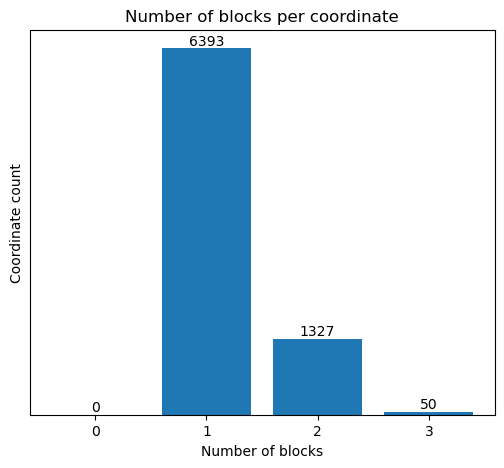

In [101]:
fig, ax = plt.subplots(figsize=(6,5))
p = plt.bar([str(i) for i in range(max_csl)],csl_count,)
for rect in p:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

# plt.yscale("log")
# ax.get_yaxis().set_visible(False)

plt.yticks([])  
ax.set_ylabel("Coordinate count")
ax.set_xlabel("Number of blocks")
ax.set_title("Number of blocks per coordinate")
fig.savefig('n_blocks_coordinate_count.png',dpi = 1000)
# ax.set_xlim()


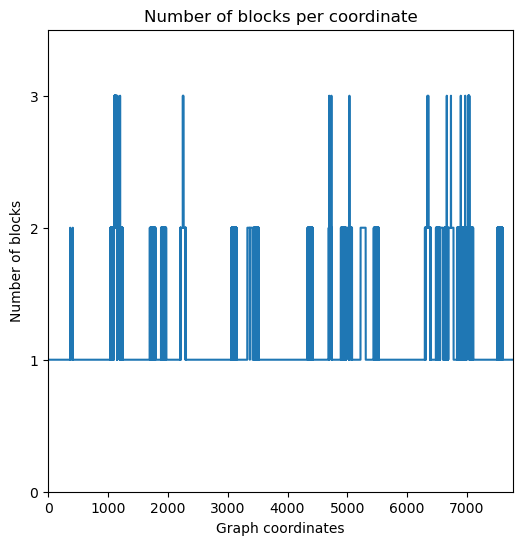

In [126]:
fig, ax = plt.subplots(figsize=(6,6))
p = plt.plot(range(len(csl)),csl)
# ax.set_aspect(len(csl)/max(csl))
ax.set_ylabel("Number of blocks")
ax.set_xlabel("Graph coordinates")
ax.set_title("Number of blocks per coordinate")
ax.set_xlim([0,len(csl)])
ax.set_ylim([0,max_csl-0.5])
# ax.set_yticklabels([0,"",1,"",2,"",3,""])
ax.set_yticks([0,1,2,3])
fig.savefig('n_blocks_coordinate.png',dpi = 1000)

In [21]:
read_sets_cano = [set(read.num()) for read in read_seqs]
read_sets_ncano = [set(read.num(canonical=False)) for read in read_seqs]
consensus_reads = np.zeros((len(read_seqs),max_3))

for i, (rs, rsn) in enumerate(zip(read_sets_cano,read_sets_ncano)):
    a = np.zeros(max_3)
    an = np.zeros(max_3)
    a = [len(cs.intersection(rs))>0 for cs in consensus_set]
    an = [len(cs.intersection(rsn))>0 for cs in consensus_set]
    af = max(a,an,key= sum)
    consensus_reads[i] = af
    
    

In [22]:
consensus_reads_l = list(consensus_reads)
consensus_reads_l.sort(key = sort_by_median)


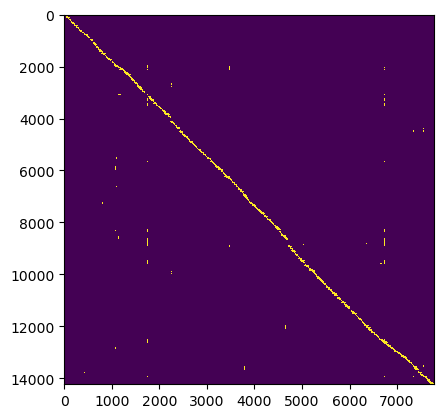

In [23]:
fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l, interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0])
fig.savefig('HM_reads.png',dpi = 500)

In [24]:
a = [456,125,312,1,234]
print(np.argsort(a))

[3 1 4 2 0]


In [25]:
consensus_reads_l_block = list(consensus_reads)
consensus_reads_l_block.sort(key = get_max_block_mean)


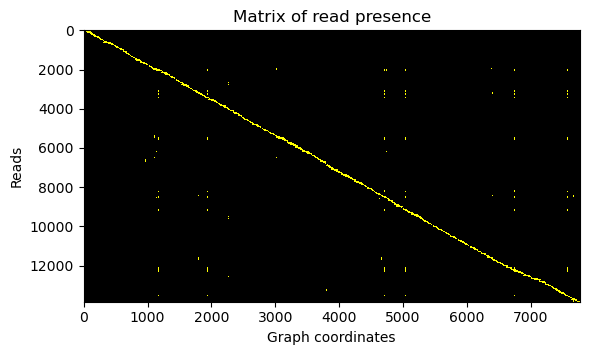

In [135]:
fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l_block, cmap="gnuplot",interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0]*9/16)
ax.set_xlabel("Graph coordinates")
ax.set_ylabel("Reads")
ax.set_title("Matrix of read presence")
fig.savefig('HM_reads_block.png',dpi = 1000, transparent=True)

In [27]:
ratio_total = [sum(consensus_reads[i])/2/len(s) for i, s in enumerate(read_seqs)]
ratio_max_block = [get_max_block(consensus_reads[i])//2/len(s) for i, s in enumerate(read_seqs)]

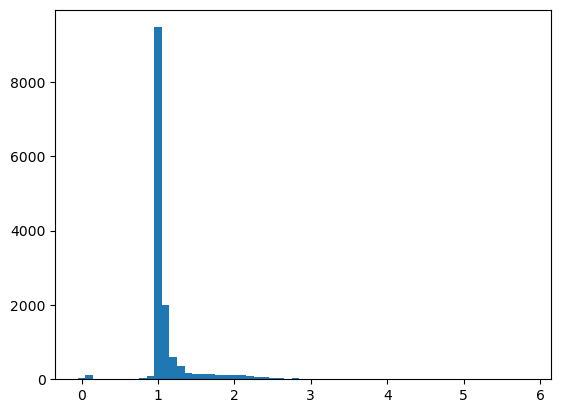

In [28]:
_ = plt.hist(ratio_total,bins = np.arange(min(ratio_total)-0.05,max(ratio_total)-0.05,0.1))

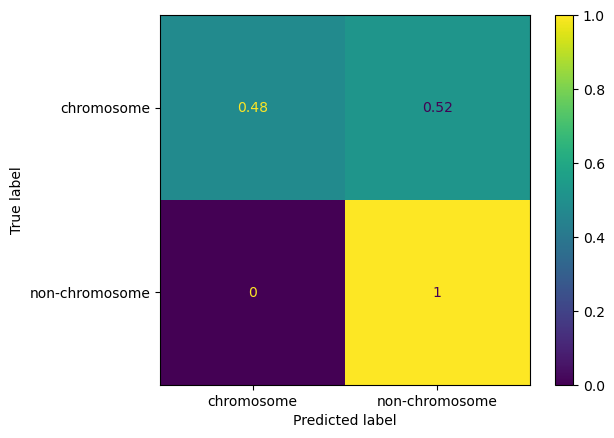

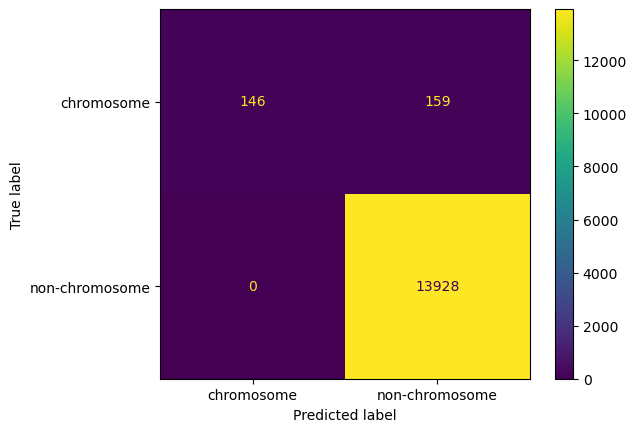

In [29]:
y_total = np.array(ratio_total)>0.5
y_ref = np.array(a_l)<1
cm = confusion_matrix(y_ref,y_total,normalize='true')
cm_display = ConfusionMatrixDisplay(cm, display_labels=["chromosome", "non-chromosome"])
cm_display.plot()
cm = confusion_matrix(y_ref,y_total)
cm_display = ConfusionMatrixDisplay(cm, display_labels=["chromosome", "non-chromosome"])
cm_display.plot()

In [30]:
[sum(ref_seqs[0].num(canonical=False)==x) for x in [ 1230, -1081,  1324, -1358, -1360,  1380,  1147]]

[0, 1, 0, 0, 0, 1, 1]

In [31]:
print(ratio_total[np.argmax(ratio_total)],read_seqs[np.argmax(ratio_total)].num())
print(ratio_max_block[np.argmax(ratio_max_block)],read_seqs[np.argmax(ratio_max_block)].num())


6.0 [ 1230 -1081  1324 -1358 -1360  1380  1147]
2.0 [2587]


In [32]:
read_seqs[1898].num()

array([2587], dtype=int16)

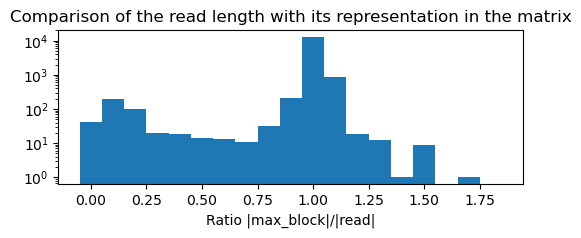

In [155]:
fig, ax = plt.subplots(figsize=(6,2))
p = plt.hist(ratio_max_block,bins = np.arange(min(ratio_max_block)-0.05,max(ratio_max_block)-0.05,0.1))
ax.set_xlabel("Ratio |max_block|/|read|")
ax.set_title("Comparison of the read length with its representation in the matrix")
ax.set_yscale('log')
fig.savefig('ratio_block_read.png',dpi = 1000)

In [34]:
y_block = np.array(ratio_max_block)>0.5
y_ref = np.array(a_l)<1

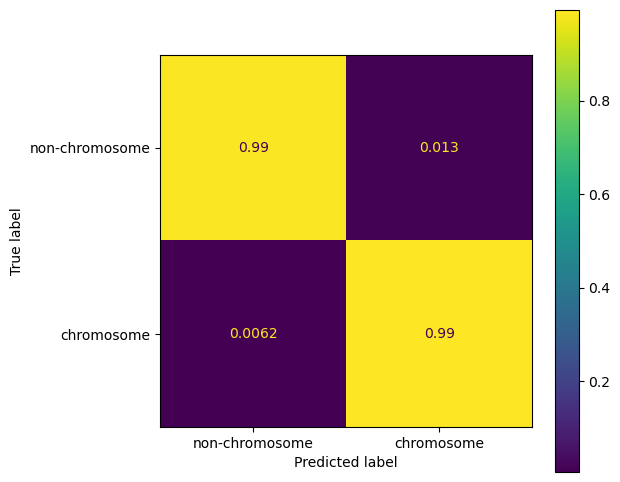

In [214]:
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_ref,y_block,normalize='true')
cm_display = ConfusionMatrixDisplay(cm, display_labels=["non-chromosome", "chromosome"])
cm_display.plot(ax=ax)
fig.savefig('cm_scaled.png',dpi = 1000)

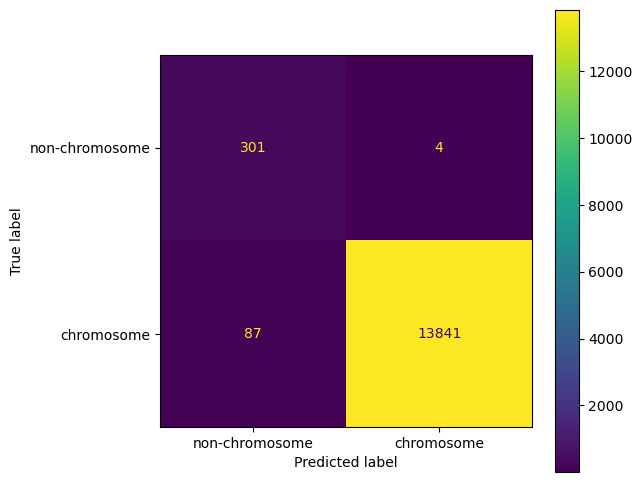

In [213]:
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_ref,y_block)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[ "non-chromosome","chromosome"])
cm_display.plot(ax=ax)
fig.savefig('cm_nscaled.png',dpi = 1000)

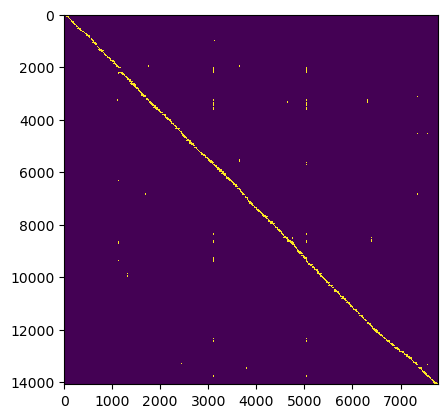

In [37]:
consensus_reads_l = list(consensus_reads[y_total])
consensus_reads_l.sort(key = get_max_block_mean)

fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l, interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0])
fig.savefig('HM_unitigs_block.png',dpi = 500)

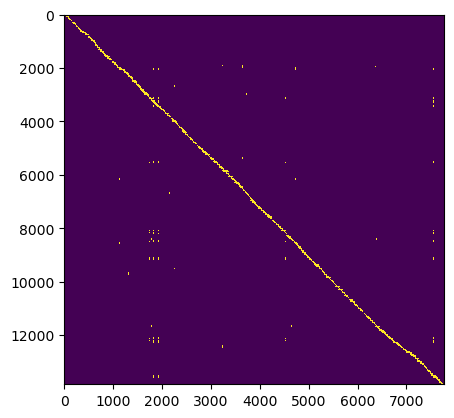

In [38]:
consensus_reads_l_block = list(consensus_reads[y_block])
consensus_reads_l_block.sort(key = get_max_block_mean)

fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l_block, interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0])
fig.savefig('HM_unitigs_block.png',dpi = 500)

In [209]:
ref = ref_seqs[0].num(canonical=False)
# m = np.zeros((),))
x,y = [],[]
for i in range(len(ref_seqs[0])):
    for j in range(len(consensus_set)):
        if ref[i] in consensus_set[j]:
            x.append(i)
            y.append(j)

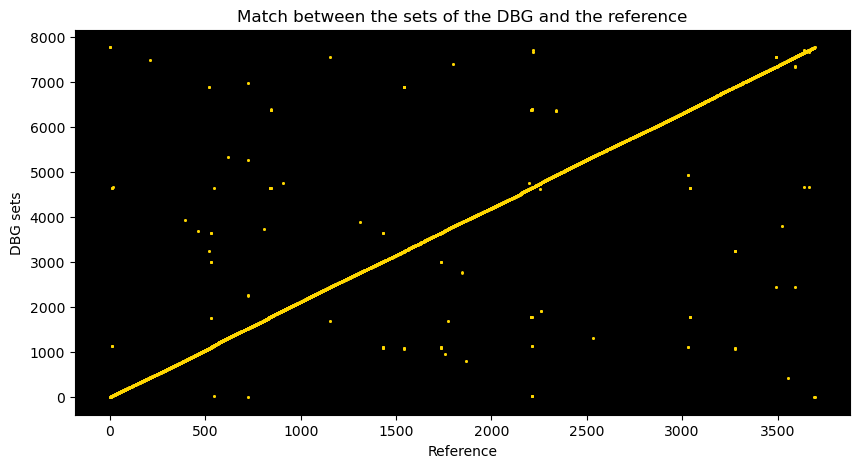

In [210]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("Reference")
ax.set_ylabel("DBG sets")
ax.set_title("Match between the sets of the DBG and the reference")
ax.set_facecolor("Black")
plt.scatter(x,y, s=1, c="gold", )

In [211]:
ref = ref_seqs[0].num(canonical=False)
# m = np.zeros((),))
x,y = [],[]
for i in range(len(ref)):
    for j in range(len(ref)):
        if ref[i] == ref[j]:
            x.append(i)
            y.append(j)

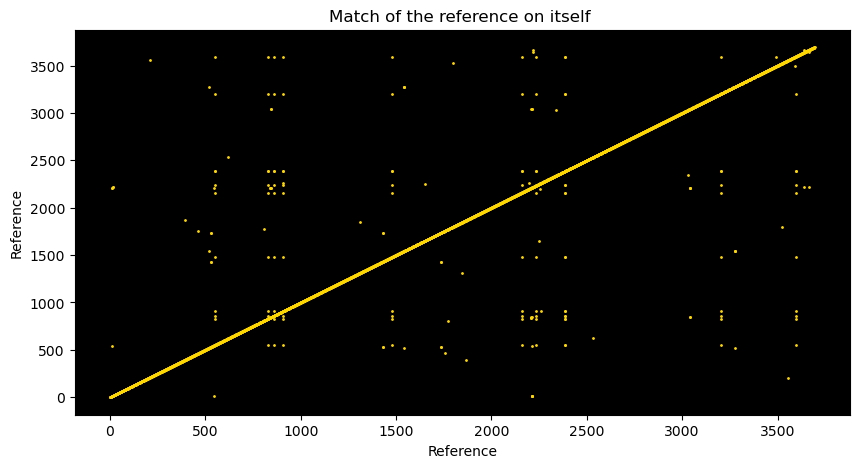

In [212]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("Reference")
ax.set_ylabel("Reference")
ax.set_title("Match of the reference on itself ")
ax.set_facecolor("Black")
plt.scatter(x,y, s=1, c="gold", )

In [39]:
a= [[] for _ in range(max([x[0] for x in coordinates.values()])+1)]
for u, c in coordinates.items():
    a[c[0]].append((u,str(u)))
for k,l in enumerate(a):
    for i,s in l:
        if s=="+rhsA.rhsB.rshA~~~+group_4333~~~+group_4643~~~-group_5018~~~-group_5020~~~+rhsA.rhsB.rshA~~~+group_4446~~~+group_4445~~~-yibH~~~-yibI~~~+mtlA~~~+mtlD~~~+mtlR~~~+yibL~~~+lldP~~~+lldR~~~+lldD~~~+trmL~~~-cysE~~~-gpsA~~~-secB~~~-grxC~~~-yibN~~~+gpmM~~~+envC~~~+yibQ~~~-waaH~~~-tdh~~~-kbl~~~+rfaD~~~+rfaF~~~+rfaC~~~+group_2413~~~-group_2414~~~-waaZ~~~-rfaY~~~-group_4451~~~-waaB~~~-group_2415~~~-rfaP~~~-rfaG~~~+waaA~~~+coaD~~~-mutM~~~-group_4343~~~+coaBC~~~+dut~~~+slmA~~~-pyrE~~~-rph~~~+yicC~~~+group_4998~~~+dinD~~~+yicG~~~-ligB~~~+gmk~~~+rpoZ~~~+spoT~~~+trmH~~~+recG~~~-gltS~~~+xanP~~~+yicH~~~-yicI~~~-group_4347~~~+setC~~~+yicL~~~-nlpA~~~+yicS~~~-nepI~~~-yicN~~~-adeQ~~~+adeD~~~-Escherichia_coli_UhpT3003890HG7388671293426629356583667.uhpT~~~-group_380~~~-uhpB~~~-uhpA3003893HG7388671293070729312983668.uhpA~~~-ilvN~~~-group_381~~~+group_4998~~~+emrD~~~-aslB~~~-yidG~~~-yidH~~~+yidI~~~-aslA.yidJ~~~-yidK~~~+yidL~~~-glvG.celF~~~-glvB~~~+yidP~~~-yidE~~~-ibpB~~~-ibpA~~~+yidQ~~~-yidR~~~+cbrA~~~-dgoT.uhpC~~~-dgoD~~~-dgoA~~~-dgoK~~~-dgoR~~~+yidX~~~-yidA~~~-yidB~~~-gyrB3003303AP0090481376029537627102063.gyrB~~~-recF~~~-dnaN~~~+rnpA~~~+yidC":
            print(k)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
l = [len(aa) for aa in a]

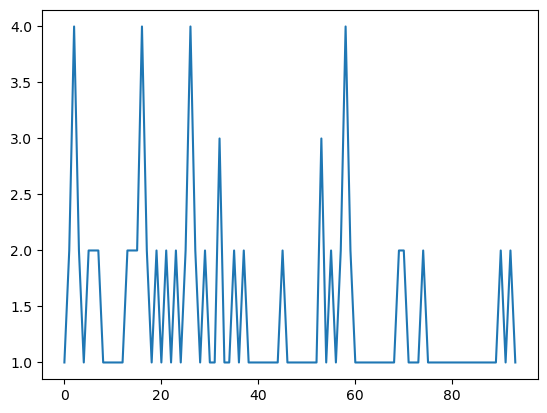

In [ ]:
plt.plot([len(aa) for aa in a])

In [ ]:
np.argmax([np.array([len(s) for s,_ in aa]).std() for aa in a])

74

In [ ]:
for aa in a[74]:
    print(str(aa[0]))

-yraJ~~~-yraI~~~-yraH~~~-agaD~~~-agaC~~~+group_5020~~~+group_5018~~~-agaC~~~-agaB~~~-kbaY~~~-agaS~~~-group_4546~~~-agaF~~~-agaE~~~-agaW~~~-agaV~~~+agaR~~~-yhaV~~~-prlF~~~-garD~~~+garP~~~+garL~~~+garR~~~+garK~~~-yhaC~~~-yhaB~~~-tdcR~~~+tdcA~~~+tdcB
+mtr~~~-yhbW~~~-rlhA~~~-ubiU~~~+yhbS~~~-yhbQ~~~+yhbP~~~-yhbO~~~+yraR~~~+yraQ~~~-dolP~~~-yraN~~~-lpoA~~~+rsmI~~~-yraK~~~-yraJ~~~-yraI~~~-yraH~~~-agaD~~~-agaC~~~+group_5020~~~+group_5018~~~-agaB~~~-kbaY~~~-agaS~~~-group_4546~~~-agaF~~~-agaE~~~-agaW~~~-agaV~~~+agaR~~~-yhaV~~~-prlF~~~-garD~~~+garP~~~+garL~~~+garR~~~+garK~~~-yhaC~~~-yhaB~~~-tdcR~~~+tdcA~~~+tdcB~~~+tdcC


In [ ]:
strs = [ "-group_5074~~~-chaA~~~+chaC~~~-ychN~~~+ychO~~~-narX~~~-group_45~~~+narK~~~+narZ~~~+narH~~~+narJ~~~+narI~~~-purU~~~+rssA~~~+rssB~~~+galU~~~-HNS3000676BA0000073173769017381045476.hns~~~+tdk~~~-group_4316~~~-adhE~~~-group_4280~~~+oppA~~~+oppB~~~+oppC~~~+oppD~~~+oppF~~~-cls~~~-clsA~~~-yciI~~~+tonB~~~-yciA~~~-yciB~~~-yciC~~~+ompW~~~-yciE~~~-yciF~~~-trpA~~~-trpB~~~-trpF~~~-trpD~~~-trpE~~~+yciV~~~+yciO~~~+group_4480~~~+rluB~~~-cobO~~~-yciK~~~-yciN~~~+topA~~~+cysB~~~+group_5020~~~+group_5018",
         "-oppA~~~+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~+group_5074",
         "+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ",
         "+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~+group_5074~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ",
         "+group_5074~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ~~~+ldcA",
         "-oppA~~~+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ~~~+ldcA",
         "+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ~~~+ldcA~~~+nhaP2~~~-dadX~~~-dadA~~~+ycgB~~~-fadR~~~+nhaB~~~+dsbB~~~-umuC~~~-umuD~~~+hlyE~~~-ycgN~~~-ycgM~~~-ycgL~~~+group_43~~~-ycgJ~~~+minC~~~+minD~~~+minE~~~-aidA.ypjA~~~+ymgG~~~+ymgD~~~-aidA~~~-group_4289~~~-pdeG~~~-ymgB~~~+bluF~~~+ycgX~~~-icd~~~+rluE~~~+nudJ~~~+mnmA~~~+purB~~~+Klebsiella_mutant_PhoP3003585FO8349061232563623263084715.phoP~~~+phoQ~~~+roxA~~~-pepT~~~+potA~~~+potB~~~-tfaX~~~+group_5108~~~-group_4703~~~+tnp.orfA~~~+tnp.tra5~~~+group_5066~~~-group_4703~~~-lomR~~~-group_4837~~~-rri1~~~-gp18~~~-group_4932~~~-group_4933~~~-group_4934~~~-group_4935~~~-group_4936~~~-group_4937~~~-group_4938~~~-group_4939~~~-group_4940~~~-group_4941~~~-group_4942~~~-group_4943~~~-group_4944~~~+iss~~~-rrrD.rrrQ~~~-group_5175~~~-essD~~~-group_4610~~~+iraM~~~-group_5076~~~-group_5247~~~-group_1886~~~-group_5161~~~-group_5243~~~+group_1061~~~+group_1899~~~+group_4383~~~+group_1900~~~+potC~~~+potD~~~+group_4458~~~+ycfZ~~~-cobB~~~-nagK~~~-lolE~~~-lolD~~~-lolC~~~+ycfT~~~+mfd~~~+ycfS~~~-bhsA~~~+comR~~~-ndh~~~-ycfP~~~-lpoB~~~-group_36~~~+fhuE~~~-ptsG~~~-ycfH~~~-holB~~~-tmk~~~-yceG~~~-pabC~~~-fabD~~~-fabH~~~-plsX~~~-yceD~~~+yceF~~~-rluC~~~+group_5020~~~+group_5018",
]
for k,c in enumerate([coordinates,coordinates_1,coordinates_2]):
    for aa in c:
        for i, s in enumerate(strs):
            if str(aa) == s:
                print(i,aa.id,k,c[aa][0])

0 112 0 34
1 113 0 33
3 39 0 32
4 176 0 31
2 208 0 32
6 132 0 30
5 435 0 32
6 132 1 27
4 176 1 28
3 39 1 29
2 208 1 29
1 113 1 30
5 435 1 28
0 112 1 31
0 112 2 30
1 113 2 29
3 39 2 28
2 208 2 28
4 176 2 27
5 435 2 29
6 132 2 26


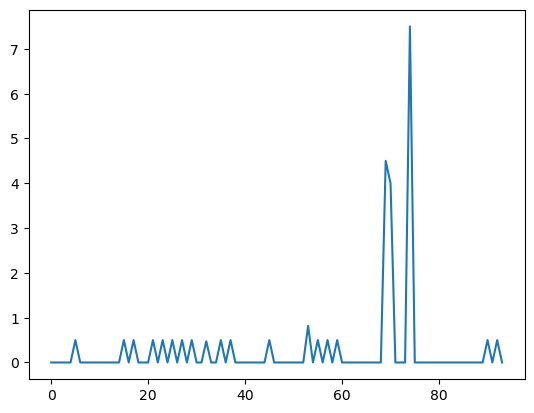

In [ ]:
plt.plot([np.array([len(s) for s,_ in aa]).std() for aa in a])

In [427]:
read_file = "../input/real_data/SRR23044204_1.subset.pandora_gene_calls.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
read_pos_file = "../input/real_data/SRR23044204_1.subset.pandora_gene_positions.json"
with open(read_pos_file, 'r') as f:
    gene_positions_reads = json.load(f)

d = [len(r)-len(r2) for r,r2 in  zip(read_data.values(),gene_positions_reads.values())]
print(sum([len(r) for r in read_data.values()]))
print(sum([len(r) for r in gene_positions_reads.values()]))

358455
358455


In [428]:
len(read_data)

14233

In [423]:
d = {}
l=[]
for r, p in zip(read_data.values(), gene_positions_reads.values()):
    for b, bp in zip(r,p):
        b = b[1:]
        if b not in d:
            d[b]=[]
        d[b].append(bp[1]-bp[0])
        l.append(bp[1]-bp[0])

In [424]:
l_mean =[]
for b in d.values():
    l_mean.append((np.mean(b),len(b)))
ll = []
for a,b in l_mean:
    ll+=([a]*b)

(array([   0.,    0.,    0.,    0.,    0.,    0.,  860.,    0.,    0.,
           0.,    0.,    0.,    0.,  335.,  430.,   95.,    0.,    0.,
         133.,    0.,    0.,  343.,  690., 1017., 3678., 3623., 2579.,
        3438., 2435., 3779., 2758., 3502., 3244., 2247., 2555., 2701.,
        2716., 3572., 3052., 3057., 2308., 2484., 3595., 3256., 2734.,
        4209., 3553., 2063., 2327., 2623., 3448., 2523., 2971., 2451.,
        3585., 3032., 2786., 2730., 3696., 2695., 2760., 3997., 2980.,
        3163., 3367., 3179., 3948., 2447., 4010., 2598., 3386., 4736.,
        3950., 3483., 2852., 2211., 3153., 3344., 3913., 2646., 1621.,
        2653., 2858., 3251., 3208., 2323., 4522., 2929., 3751., 3959.,
        2611., 2824., 3218., 2524., 3141., 2282., 3606., 2920., 2475.,
        2687., 2643., 2720., 2945., 1801., 2030., 2092., 1476., 2504.,
        2999., 1770., 1777., 1977., 2346., 2631., 2417., 1608., 1650.,
        2542., 2616., 2180., 2243., 1618., 2097., 2143., 1552., 1969.,
      

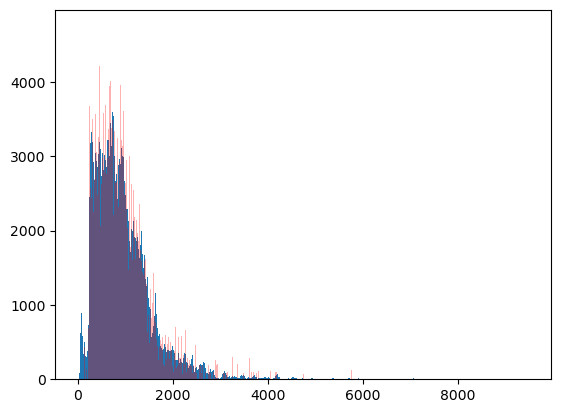

In [425]:
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
ax1.hist(l,bins=range(0,max(l)+10,10))
ax1.hist(ll,bins=range(0,max(l)+10,10),color="red", alpha=0.3)


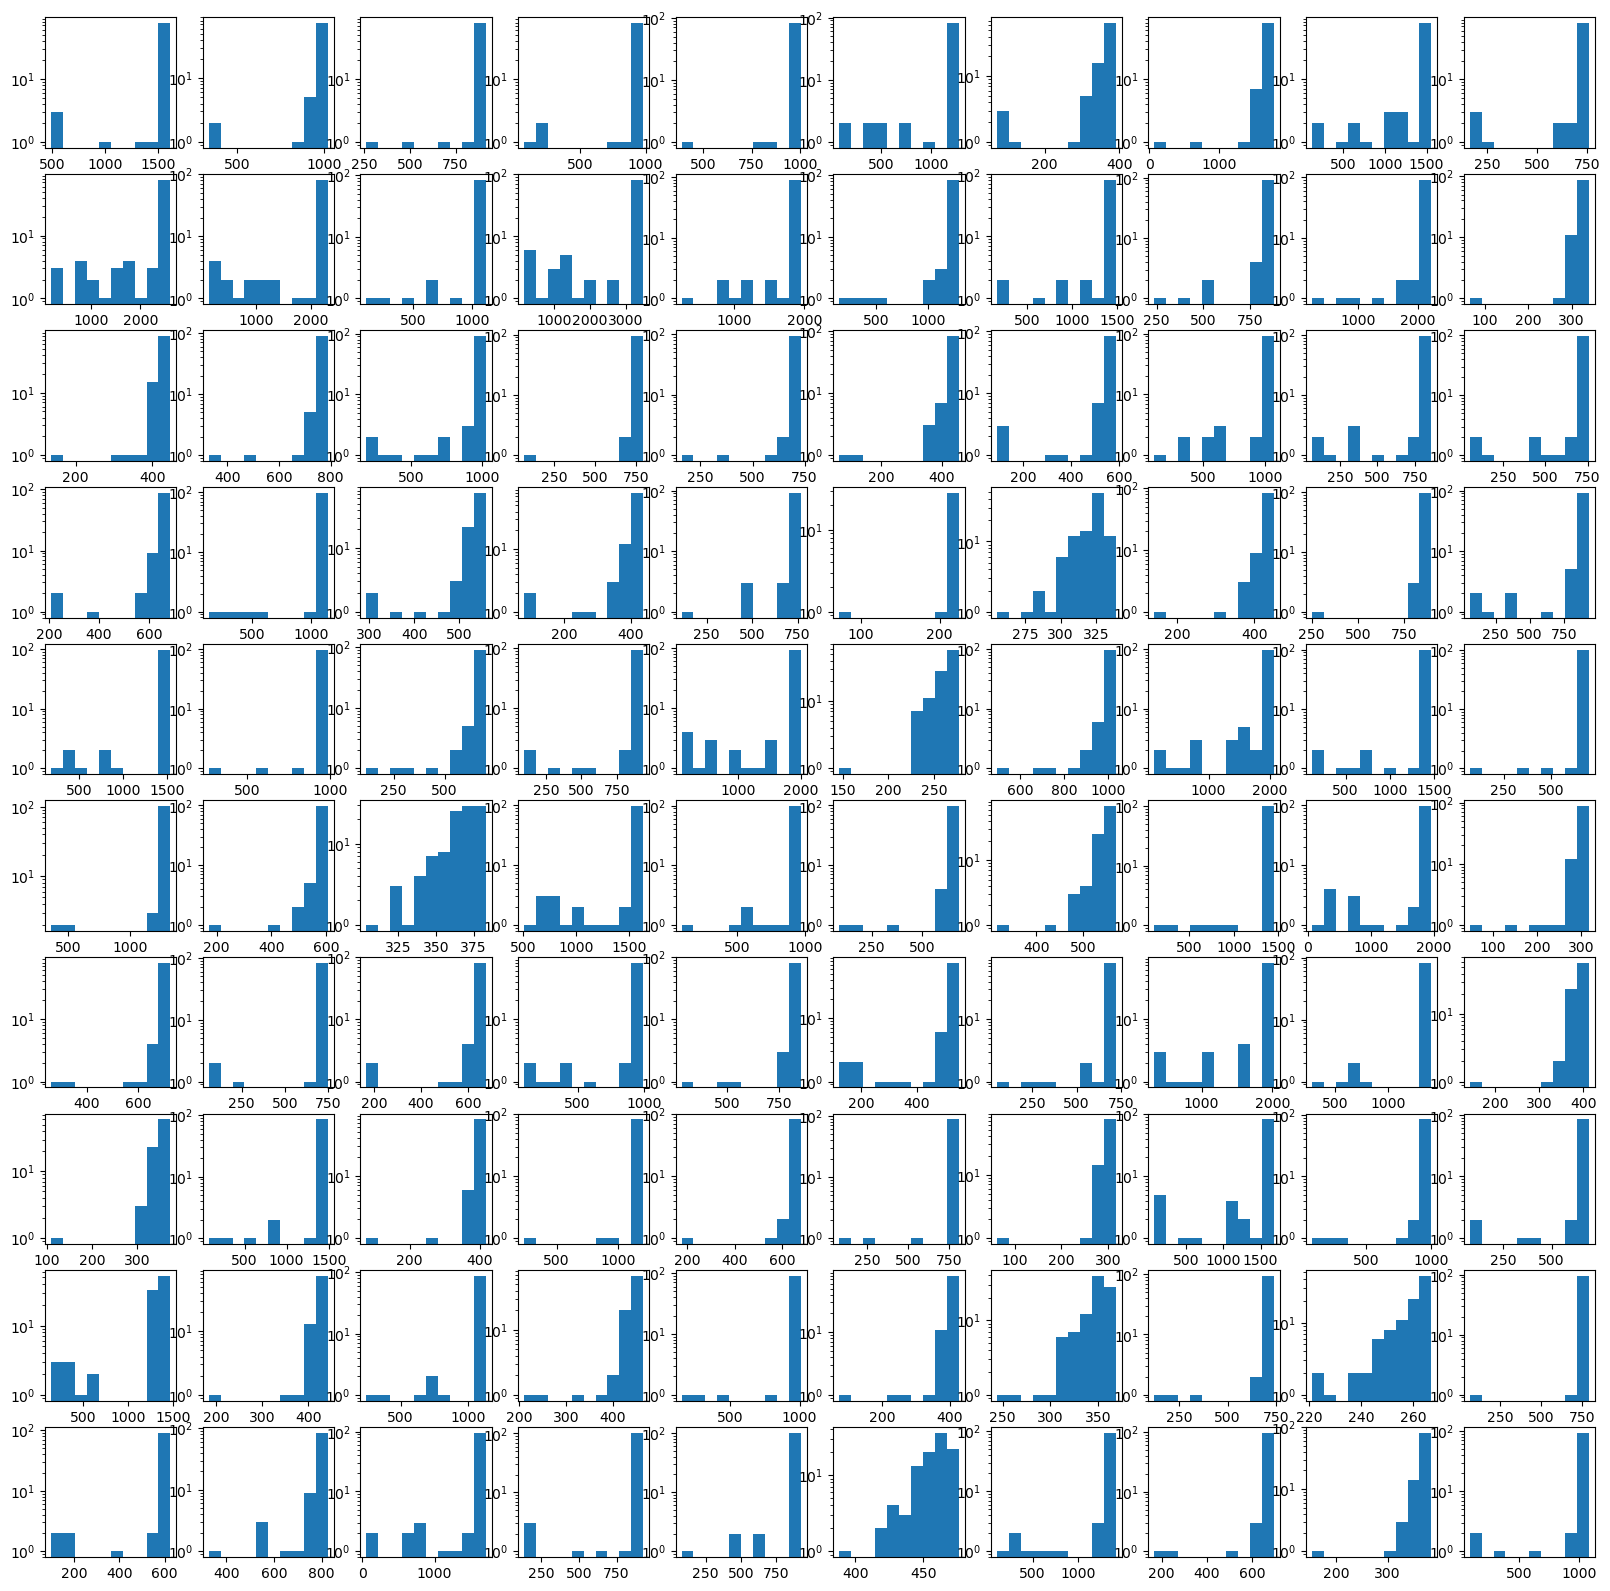

In [426]:
fig, axs = plt.subplots(10,10,figsize = (20,20))
axs = axs.flatten()
for k, (ax,b) in enumerate(zip(axs,list(d.keys())[:100])):
    ax.hist(d[b])
    ax.set_yscale('log')

In [385]:
for b in d:
    print(d[b])

[1290, 1596, 964, 1585, 1573, 1573, 1586, 1586, 1587, 1577, 1599, 597, 1587, 1595, 1577, 1590, 1587, 1586, 1601, 1559, 1545, 1609, 1590, 1575, 1577, 1600, 1596, 1600, 1581, 1585, 1491, 1583, 1610, 1601, 1575, 1587, 1603, 1593, 1591, 1558, 1593, 1585, 1600, 1595, 1598, 1563, 1586, 1586, 1528, 1517, 1600, 1591, 1604, 1583, 568, 1593, 1591, 1579, 1592, 1590, 1605, 1554, 1580, 491, 1572, 1538, 1593, 1564, 1553, 1588, 1613, 1548, 1588, 1577, 1593, 1588, 1575, 1597, 1544, 1599, 1595, 1587]
[1007, 999, 1006, 1000, 1007, 965, 950, 1005, 1012, 1013, 1016, 1010, 1020, 1018, 1013, 337, 1015, 1013, 1016, 984, 365, 953, 982, 1003, 1014, 1012, 822, 1012, 1004, 1006, 965, 1013, 1008, 1012, 983, 1008, 1013, 1015, 992, 1008, 1015, 1010, 1013, 1016, 997, 1011, 1005, 1015, 997, 1006, 1017, 1015, 1000, 954, 994, 1010, 1009, 986, 1007, 1005, 999, 1011, 931, 1005, 967, 997, 1018, 994, 992, 1008, 939, 1004, 989, 1010, 999, 1013, 1016, 1023, 1021, 1004, 1020]
[883, 900, 876, 877, 897, 899, 895, 262, 876, 899,

In [381]:
[np.std(b)  for b in d.values()]

[206.4776178970616,
 104.23384335957739,
 87.38006128689456,
 151.11972357069422,
 70.53899262797037,
 245.2756635117131,
 200.52491002438887,
 113.5303596187346,
 612.6852444503461,
 557.3473068018769,
 160.4660019374128,
 970.7992137996575,
 261.2360707575241,
 192.85020908692903,
 228.08786372853535,
 88.90516014270487,
 377.860307934716,
 28.830572314818866,
 35.92030255864362,
 55.706993252393566,
 158.8092120957901,
 73.38166021258688,
 66.88087261143407,
 53.603976165499816,
 84.83887851780999,
 165.04057804067457,
 146.56277811570737,
 115.42281692398026,
 68.1026186716364,
 135.86936106298288,
 42.05139441886936,
 59.19551693602128,
 75.96451896208822,
 12.891965892289928,
 35.49832902529433,
 63.5384383635497,
 161.39445219429982,
 242.45559825866601,
 80.91485092367161,
 82.6205060787179,
 140.88807842430785,
 458.46814925011364,
 16.09333618845254,
 68.4580839584286,
 382.5989642582995,
 239.0510057545415,
 71.02447982698554,
 160.13657045896147,
 46.75830070487224,
 14.582

In [367]:
print(len(read_data), len(gene_positions_reads))

14233 14233


In [272]:
l = []
for r,r2 in  zip(read_data.values(),gene_positions_reads.values()):
    if len(r)!=len(r2):
        l.append(r)

In [304]:
d={}
c=0
for ll in l:
    for b in ll:
        b = b[1:]
        if b in d:
            d[b]+=1
        else:
            d[b]=1
        if b=="tnp.yhhI":
            c+=1

In [305]:
c

93

In [292]:
np.array(d.values()).shape

()

In [301]:
has1 = []
for dd,i in d.items():
    if i==max(d.values()):
        has1.append(dd)

In [302]:
has1.sort()

In [303]:
for b in has1:
    print(b)

tnp.yhhI


In [268]:
s= set()
for ll in l:
    s = s.intersection(set(ll))

In [270]:
len(l)

102

In [2]:
read_file = "../input/new_data/SRR23044204_1.pandora_gene_calls.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
read_pos_file = "../input/new_data/SRR23044204_1.pandora_gene_positions.json"
with open(read_pos_file, 'r') as f:
    gene_positions_reads = json.load(f)

print(sum([len(r) for r in read_data.values()]))
print(sum([len(r) for r in gene_positions_reads.values()]))

380533
380533


In [3]:
from Bio import SeqIO

In [12]:
fastq = SeqIO.to_dict(SeqIO.parse("../input/new_data/SRR23044204_1.fastq","fastq"))

In [38]:
for d in [read_data, gene_positions_reads, fastq]:
    print(len(d))
print(len(set(read_data).intersection(set(fastq))))
print(len(set(gene_positions_reads).intersection(set(fastq))))
print(len(set(read_data).intersection(set(gene_positions_reads))))

subset = set(read_data)

14452
14452
14744
14452
14452
14452


In [21]:
s = fastq[list(fastq.keys())[0]].seq

In [47]:
l1 = [len(s.seq) for i,s in fastq.items()]
l2 = [len(s.seq) for i,s in fastq.items() if i in subset]

l3 = [len(s.seq) for i,s in fastq.items() if i not in subset]

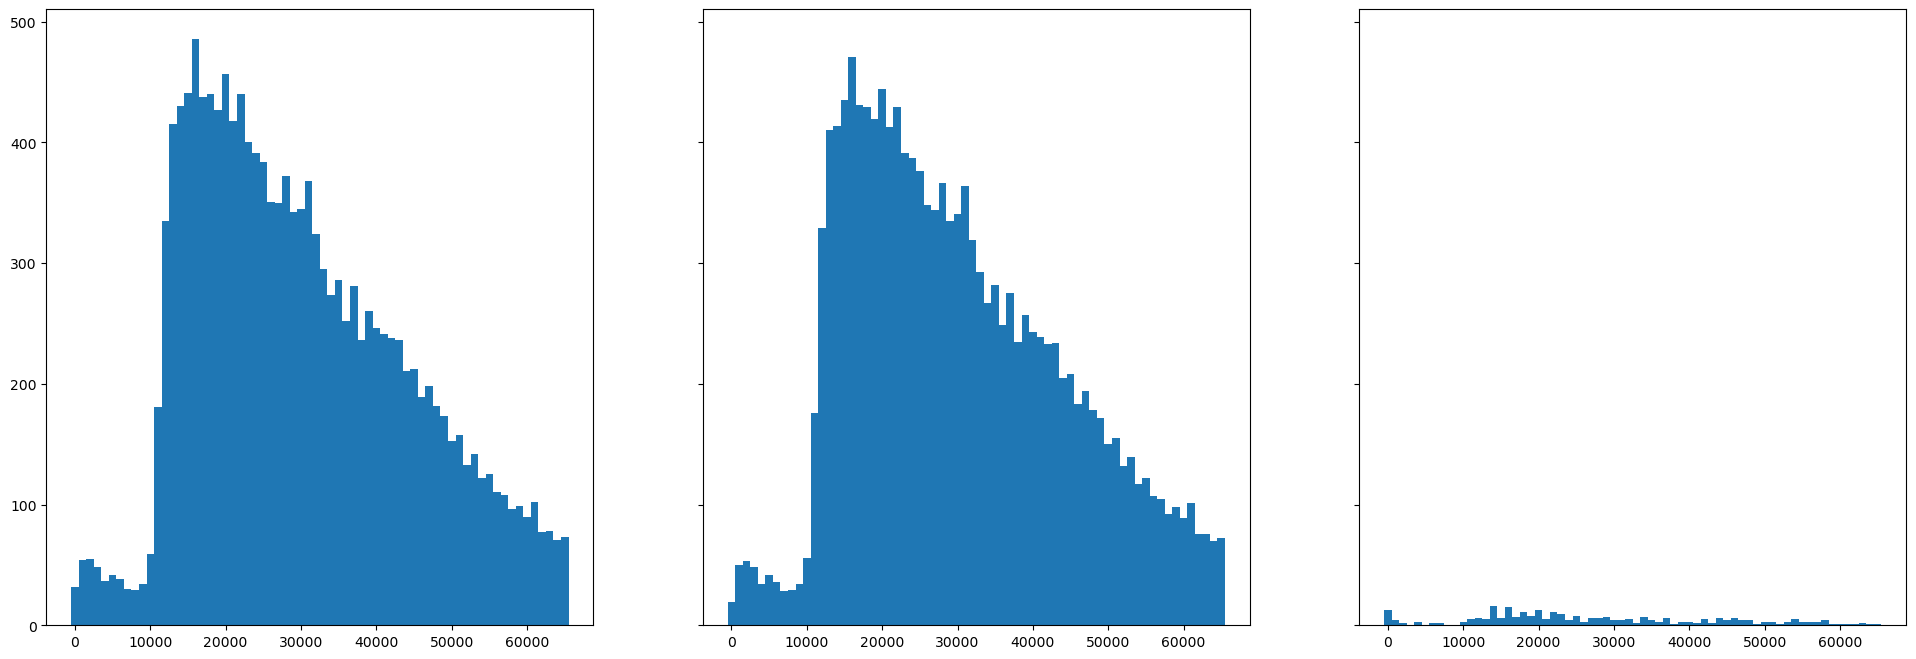

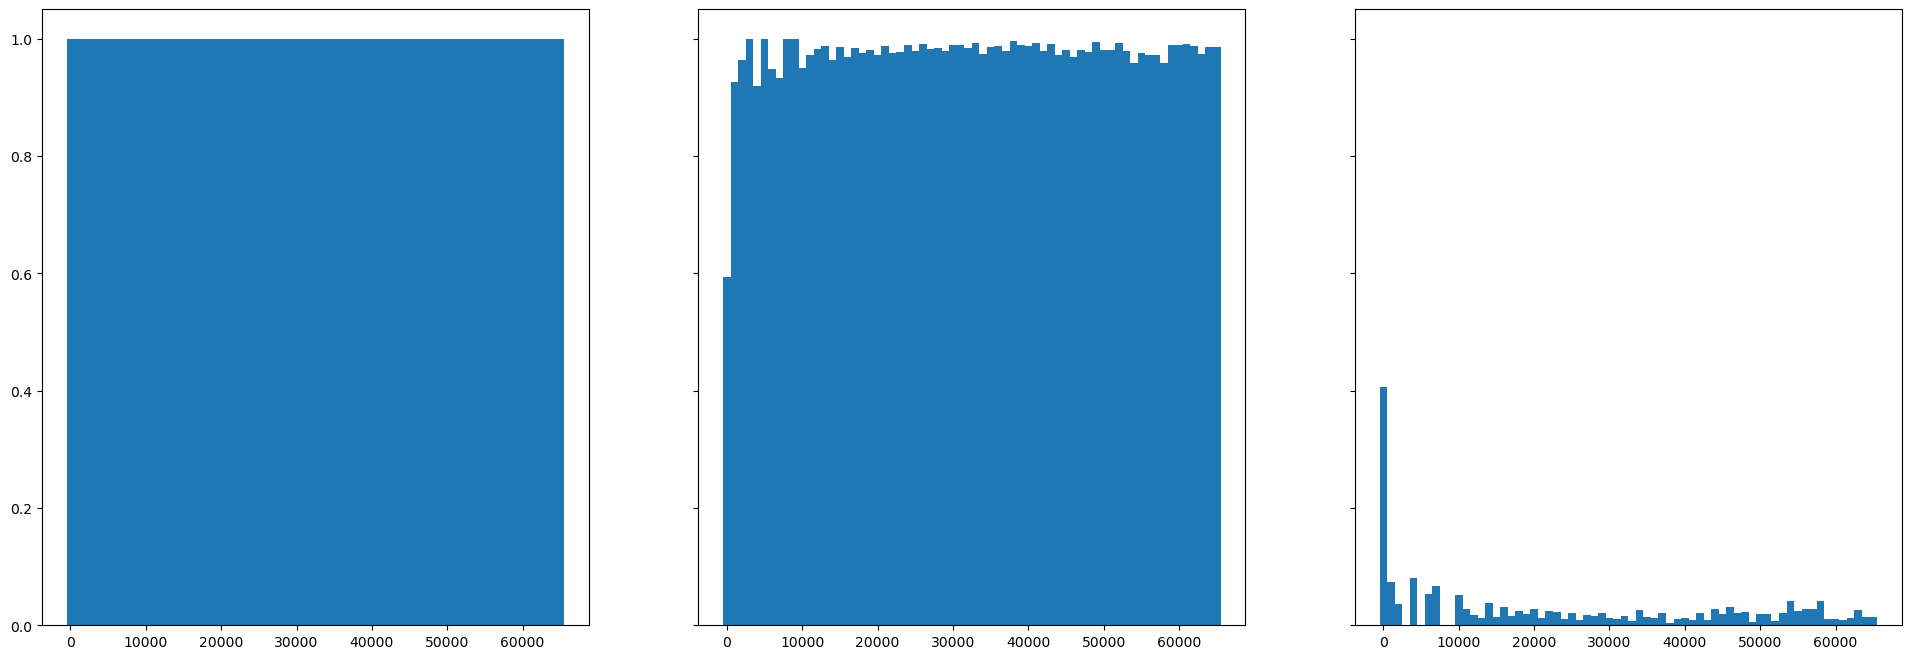

In [63]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize = (24,8))
a1 = axs[0].hist(l1,bins = np.array(range(0,max(l1)+1000,1000))-500)
a2 = axs[1].hist(l2,bins = np.array(range(0,max(l1)+1000,1000))-500)
a3 = axs[2].hist(l3,bins = np.array(range(0,max(l1)+1000,1000))-500)


fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize = (24,8))
axs[0].bar((a1[1][:-1]+a1[1][1:])/2,a1[0]/a1[0],width = 1000)
axs[1].bar((a1[1][:-1]+a1[1][1:])/2,a2[0]/a1[0],width = 1000)
axs[2].bar((a1[1][:-1]+a1[1][1:])/2,a3[0]/a1[0],width = 1000)
pass

In [70]:
blocks2reads = {}
for k,g in read_data.items():
    for block in g:
        add_to_dict(blocks2reads,block[1:],(k,block[0]=="-"))
blocks = list(blocks2reads.keys())
blocks.sort()

alphabet = [("+"+p1,"-"+p1) for p1 in blocks]
bi_alphabet = (alphabet,{k:((i+1)*((-1)**j)) for i, ks in enumerate(alphabet) for j, k in enumerate(ks)})

In [79]:
block_sequences = {k:[] for k in blocks}
for read_id in read_data:
    s_read = fastq[read_id]
    read, read_pos = read_data[read_id], gene_positions_reads[read_id]
    for block, (block_b, block_e) in zip(read, read_pos):
        r = block[0]=="-"
        s = s_read[block_b:block_e+1]
        if r:
            s= s.reverse_complement()
        block_sequences[block[1:]].append(s)


In [80]:
l, m, s = [],[],[]
for b in block_sequences:
    l.append([len(bb) for bb in block_sequences[b]])
    m.append(np.mean(l[-1]))
    s.append(np.std(l[-1]))


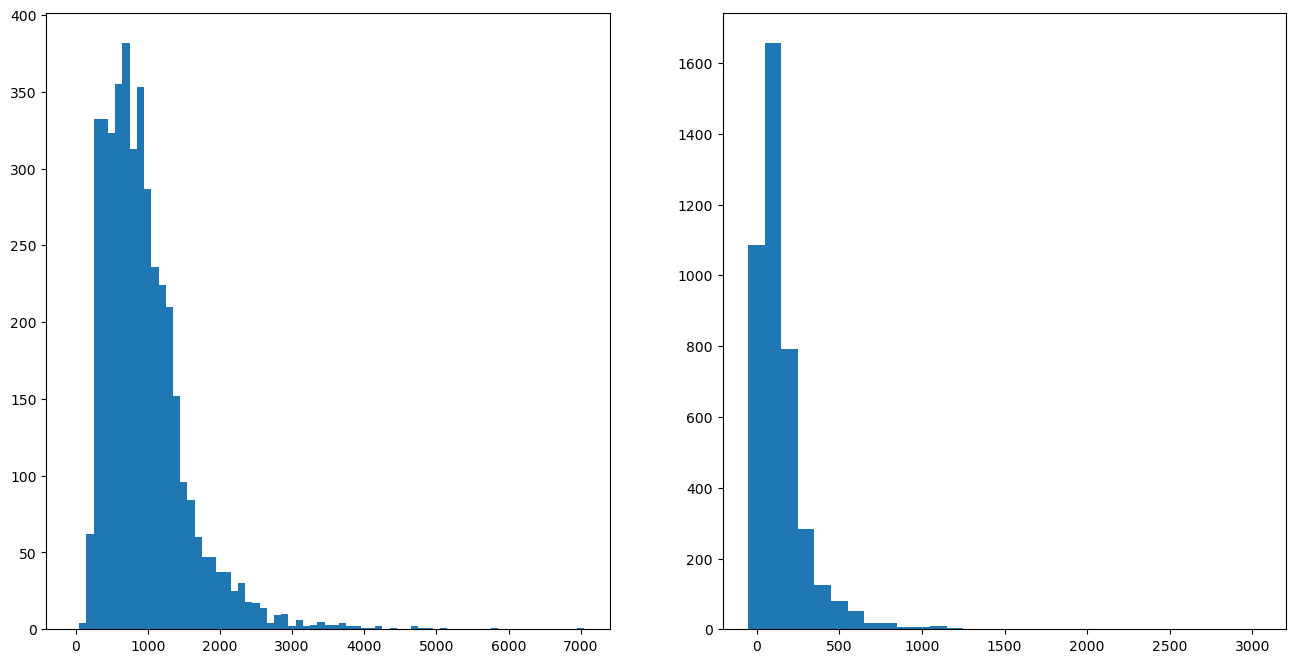

In [92]:
fig, axs = plt.subplots(1,2, figsize = (16,8))
step = 100
axs[0].hist(m,bins = np.array(range(0,np.ceil(max(m)).astype(int)+step,step))-step//2)
axs[1].hist(s,bins = np.array(range(0,np.ceil(max(s)).astype(int)+step,step))-step//2)
pass

In [94]:
m[0]

739.4193548387096

In [98]:
block_sequences[blocks[0]][2].__len__()

746

In [14]:
from collections import deque
from itertools import product

def needleman_wunsch(x, y):
    # get the lengths of x and y
    N, M = len(x), len(y)

    def score(a, b):
        # Scoring function: returns 1 if elements are equal, 0 otherwise
        return int(a == b)

    # Direction constants for traceback
    DIAG, LEFT, UP = (-1, -1), (-1, 0), (0, -1)
    # Initialize score (F) and pointer (Ptr) matrices
    F, Ptr = {}, {}
    F[-1, -1] = 0
    # Initial scoring for gaps along x
    for i in range(N):
        F[i, -1] = -i
    # Initial scoring for gaps along y
    for j in range(M):
        F[-1, j] = -j
    # Option for Ptr to trace back alignment
    option_Ptr = DIAG, LEFT, UP
    # Fill F and Ptr tables
    for i, j in product(range(N), range(M)):
        # Score options: match/mismatch, gap in x, gap in y
        option_F = (
            F[i - 1, j - 1] + score(x[i], y[j]),  # Match/mismatch
            F[i - 1, j] - 1,  # Gap in x
            F[i, j - 1] - 1,  # Gap in y
        )
        # Choose best option for F and Ptr
        F[i, j], Ptr[i, j] = max(zip(option_F, option_Ptr))
    # Trace back to get the alignment
    alignment = []
    i, j = N - 1, M - 1
    while i >= 0 and j >= 0:
        direction = Ptr[i, j]
        # Add aligned elements or gaps based on direction
        if direction == DIAG:
            element = x[i], y[j]
        elif direction == LEFT:
            element = x[i], "*"  # Insert gap in y
        elif direction == UP:
            element = "*", y[j]  # Insert gap in x
        alignment.append(element)
        di, dj = direction
        i, j = i + di, j + dj
    # Add remaining gaps if any
    while i >= 0:
        alignment.append((x[i], "*"))  # Gap in y
        i -= 1
    while j >= 0:
        alignment.append(("*", y[j]))  # Gap in x
        j -= 1
    return alignment[::-1]

def needleman_wunsch_inclusion(x, y):
    # get the lengths of x and y
    N, M = len(x), len(y)

    def score(a, b):
        # Scoring function: returns 1 if elements are equal, 0 otherwise
        return int(a in b)

    # Direction constants for traceback
    DIAG, LEFT, UP = (-1, -1), (-1, 0), (0, -1)
    # Initialize score (F) and pointer (Ptr) matrices
    F, Ptr = {}, {}
    F[-1, -1] = 0
    # Initial scoring for gaps along x
    for i in range(N):
        F[i, -1] = -i
    # Initial scoring for gaps along y
    for j in range(M):
        F[-1, j] = -j
    # Option for Ptr to trace back alignment
    option_Ptr = DIAG, LEFT, UP
    # Fill F and Ptr tables
    for i, j in product(range(N), range(M)):
        # Score options: match/mismatch, gap in x, gap in y
        option_F = (
            F[i - 1, j - 1] + score(x[i], y[j]),  # Match/mismatch
            F[i - 1, j] - 1,  # Gap in x
            F[i, j - 1] - 1,  # Gap in y
        )
        # Choose best option for F and Ptr
        F[i, j], Ptr[i, j] = max(zip(option_F, option_Ptr))
    # Trace back to get the alignment
    alignment = []
    i, j = N - 1, M - 1
    while i >= 0 and j >= 0:
        direction = Ptr[i, j]
        # Add aligned elements or gaps based on direction
        if direction == DIAG:
            element = x[i]
        elif direction == LEFT:
            element = x[i] # Insert gap in y
        elif direction == UP:
            element = "*"  # Insert gap in x
        alignment.append(element)
        di, dj = direction
        i, j = i + di, j + dj
    # Add remaining gaps if any
    while i >= 0:
        alignment.append(x[i])  # Gap in y
        i -= 1
    while j >= 0:
        alignment.append("*")  # Gap in x
        j -= 1
    return alignment[::-1]

In [17]:

import numpy as np
from time import time 
a, b = [2,3,5,6], [[1],[2],[3,4],[2],[5],[6],[7,8]]

needleman_wunsch_inclusion(a,b)

['*', 2, 3, '*', 5, 6, '*']

In [7]:
len(read_data)

14452

In [8]:
seq = ["+kdsA","-chaA","+chaC","-ychN","+ychO","-group_2250","-narX","+narK","+group_237","+group_237"]
seq1 = ["+kdsA","-chaA","+chaC","-ychN","+ychO","-group_2250","-narX","+narK","+group_237"]
seq2 = ["-chaA","+chaC","-ychN","+ychO","-group_2250","-narX","+narK","+group_237","+group_237"]

In [362]:
from data.data import Sequence

s = Sequence(0,numseq2bytes(seq2num(seq2,bi_alphabet),Sequence.n_b),1)

In [363]:
s1,s2 = s.blocks(),s.blocks(canonical=False)

In [365]:
for d in read_data.values():
    for s in [s1,s2]:
        for k in range(len(d)-len(s)):
            # print(len(s),len(d[k:k+10]))
            # if s == d[k:k+len(s)+1]:
            if s == d[k:k+9]:
                print(s[:],d[k-1:k+11])
                # print(s[:]==d[k:k+10])

['-chaA', '+chaC', '-ychN', '+ychO', '-group_2250', '-narX', '+narK', '+group_237', '+group_237'] ['-group_5897', '-chaA', '+chaC', '-ychN', '+ychO', '-group_2250', '-narX', '+narK', '+group_237', '+group_237', '+group_519', '+narJ']


In [244]:
x,y , z = [],[] , []
l = []
c = 0
for r in gene_positions_reads:
    e = None
    for i,b in enumerate(gene_positions_reads[r]):
        c+=1
        ns, ne = b
        if e is not None:
            l.append(ns-e)
        e= ne
        x.append(list(b))
        y.append([i,i])
        z.append([j,j])

In [245]:
c

380533

In [242]:
c

358353

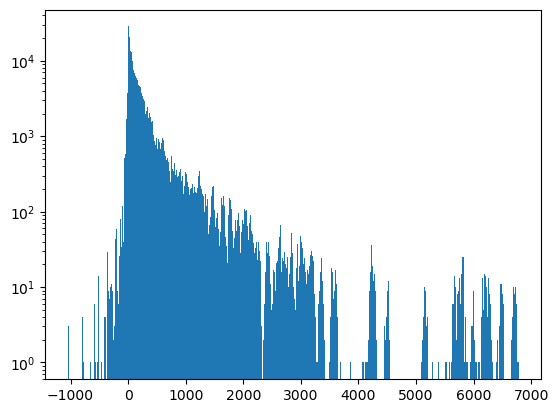

In [240]:
plt.hist(l, bins = range(min(l),max(l)+10,10))
plt.yscale("log")

In [231]:
l

[311, 26, 15, 28, 34, 278, 27, 206, 499, 15, 46, 7, -14, 145, 194, 228]

In [230]:
gene_positions_reads[r]

[[22, 1312],
 [1623, 2630],
 [2656, 3539],
 [3554, 4529],
 [4557, 5522],
 [5556, 6812],
 [7090, 7452],
 [7479, 9140],
 [9346, 10873],
 [11372, 12111],
 [12126, 14736],
 [14782, 17089],
 [17096, 18183],
 [18169, 21600],
 [21745, 23675],
 [23869, 25146],
 [25374, 26239]]

 ...]

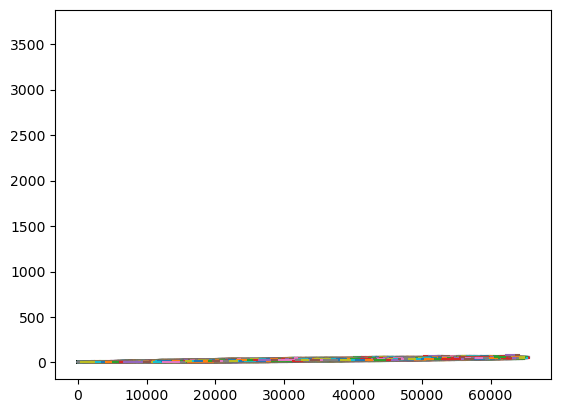

In [237]:
plt.plot(np.array(x).T,np.array(y).T,np.array(z).T)

In [10]:
import gfapy

In [19]:
a = gfapy.Gfa().from_file("../input/new_data/GFAs/post_correction/gene_mer_graph.k_7_short.gfa")
plasmid = [n.split("~~~") for n in a.names]
plasmid = [Sequence(k, numseq2bytes(seq2num(seq, bi_alphabet),n_b=2),1) for k, seq in enumerate(plasmid)]


In [12]:
# from data.data import Sequence
# from common.utils import seq2num, numseq2bytes
# from graph.graph import get_kmer_count_from_sequences, get_unitigs_bcalm
# plasmid = ["+group_3621~~~-group_3790~~~-chrA~~~-sul1NG_0480981~~~+group_3621~~~-group_3790~~~-chrA".split("~~~")]
# alphabet = [("+"+p1[1:],"-"+p1[1:]) for p1 in plasmid[0]]
# bi_alphabet = (alphabet,{k:((i+1)*((-1)**j)) for i, ks in enumerate(alphabet) for j, k in enumerate(ks)})
# Sequence.n_b = 2
# plasmid = [Sequence(k, numseq2bytes(seq2num(seq, bi_alphabet),n_b=2),1) for k, seq in enumerate(plasmid)]

# k=3
# kmers = get_kmer_count_from_sequences(plasmid, k=k, cyclic=False)
# [kmer.compute_abundance("max_unitigs_reads") for kmer in kmers]
# kmers.compute_edges(k)
# unitigs = get_unitigs_bcalm(kmers, k, on_unitig=False)
# unitigs.compute_edges(k)
# print(unitigs.get_edges())
# for u in unitigs:
#     print(len(u),u.num())


In [20]:
k=7
kmers = get_kmer_count_from_sequences(plasmid, k=k, cyclic=False)
[kmer.compute_abundance("max_unitigs_reads") for kmer in kmers]
kmers.compute_edges(k)
unitigs = get_unitigs_bcalm(kmers, k, on_unitig=False)
unitigs.compute_edges(k)

[(3, 3, 1),
 (1, 3, 2),
 (4, 4, 1),
 (1, 2, 2),
 (1, 2, -2),
 (2, 3, 1),
 (0, 0, 1),
 (0, 2, -2),
 (0, 1, 1)]

In [21]:
g_cleaned = get_gt_graph(unitigs)
g_cleaned.save(os.path.join(RES_OUTPUT_FOLDER,"c_graph_clean_{}k_{}_{}.graphml".format("OOPS",7,7)))

In [22]:
print(unitigs.get_edges())
for u in unitigs:
    print(len(u),u.num()[:10], u.num()[-10:])

[(0, 0, 1), (0, 1, 1), (0, 2, -2), (1, 2, 2), (1, 2, -2), (1, 3, 2), (2, 3, 1), (3, 3, 1), (4, 4, 1)]
9 [  269  2061 -2062   269  2061 -2062   269  2061 -2062] [  269  2061 -2062   269  2061 -2062   269  2061 -2062]
33 [  269  2061 -2062   269  2061 -2062   781  2017  1063  2015] [-2944 -3558 -2517  1369 -1394 -1370 -4089 -1074 -1759 -1323]
44 [ 2062 -2061  -269  2062 -2061  -269 -2037  1632  1489 -1570] [ 1103  1478 -2370 -2368  1323  1759  1074  4089  1370  1394]
110 [ 1323  1759  1074  4089  1370  1394  1425  3420  1971 -1410] [3873 3260 3529 3545 1323 1759 1074 4089 1370 1394]
4038 [ -77 2399   79   80   75   76 1951   78 2398 1415] [-921  918 3108 4456  -77 2399   79   80   75   76]


+group_3621~~~-group_3790~~~-chrA~~~-sul1NG_0480981~~~-qacEdelta1~~~-aadA5~~~-dfrA17~~~+xerD.intI1~~~+group_5456~~~-group_4153~~~+group_86~~~-tetRA~~~+group_5882~~~-group_1600~~~-group_2409~~~-pemK~~~-pemI~~~-mcmM~~~-repA~~~-copB.repA2~~~-group_75~~~-group_5493~~~-group_111~~~-group_2375~~~-finO~~~-group_5439~~~-traI~~~+vapC~~~-group_215~~~-traT~~~-group_5204~~~-traG~~~-traH~~~-group_3809~~~-trbB~~~-traQ~~~-trbA~~~-traF~~~-trbE~~~-traN~~~-trbC~~~-traU~~~-traW~~~-trbI~~~-traC~~~-traV~~~-trbG~~~-traP~~~-traB~~~-traK~~~-traE~~~-traL~~~-traA~~~-group_2267~~~-group_5437~~~+yubQ~~~-yubP~~~-yubO~~~-group_5439~~~-group_2349~~~+group_3722~~~-group_636~~~-rafD~~~-rafB~~~-rafA~~~-rafR~~~-group_5150~~~-group_5298~~~+group_2867~~~-group_5435~~~-rsmA~~~-group_30~~~-group_28~~~-group_27~~~-ychA~~~-group_121~~~-group_477~~~-group_25~~~-spo0J~~~-sopA~~~-repB.repE~~~-xerD~~~-ccdB~~~+vapC.pilT~~~+group_499~~~+group_5240~~~+group_3722~~~-group_3905~~~+group_2788~~~+nqrC~~~+group_306~~~+group_2707~~~+group

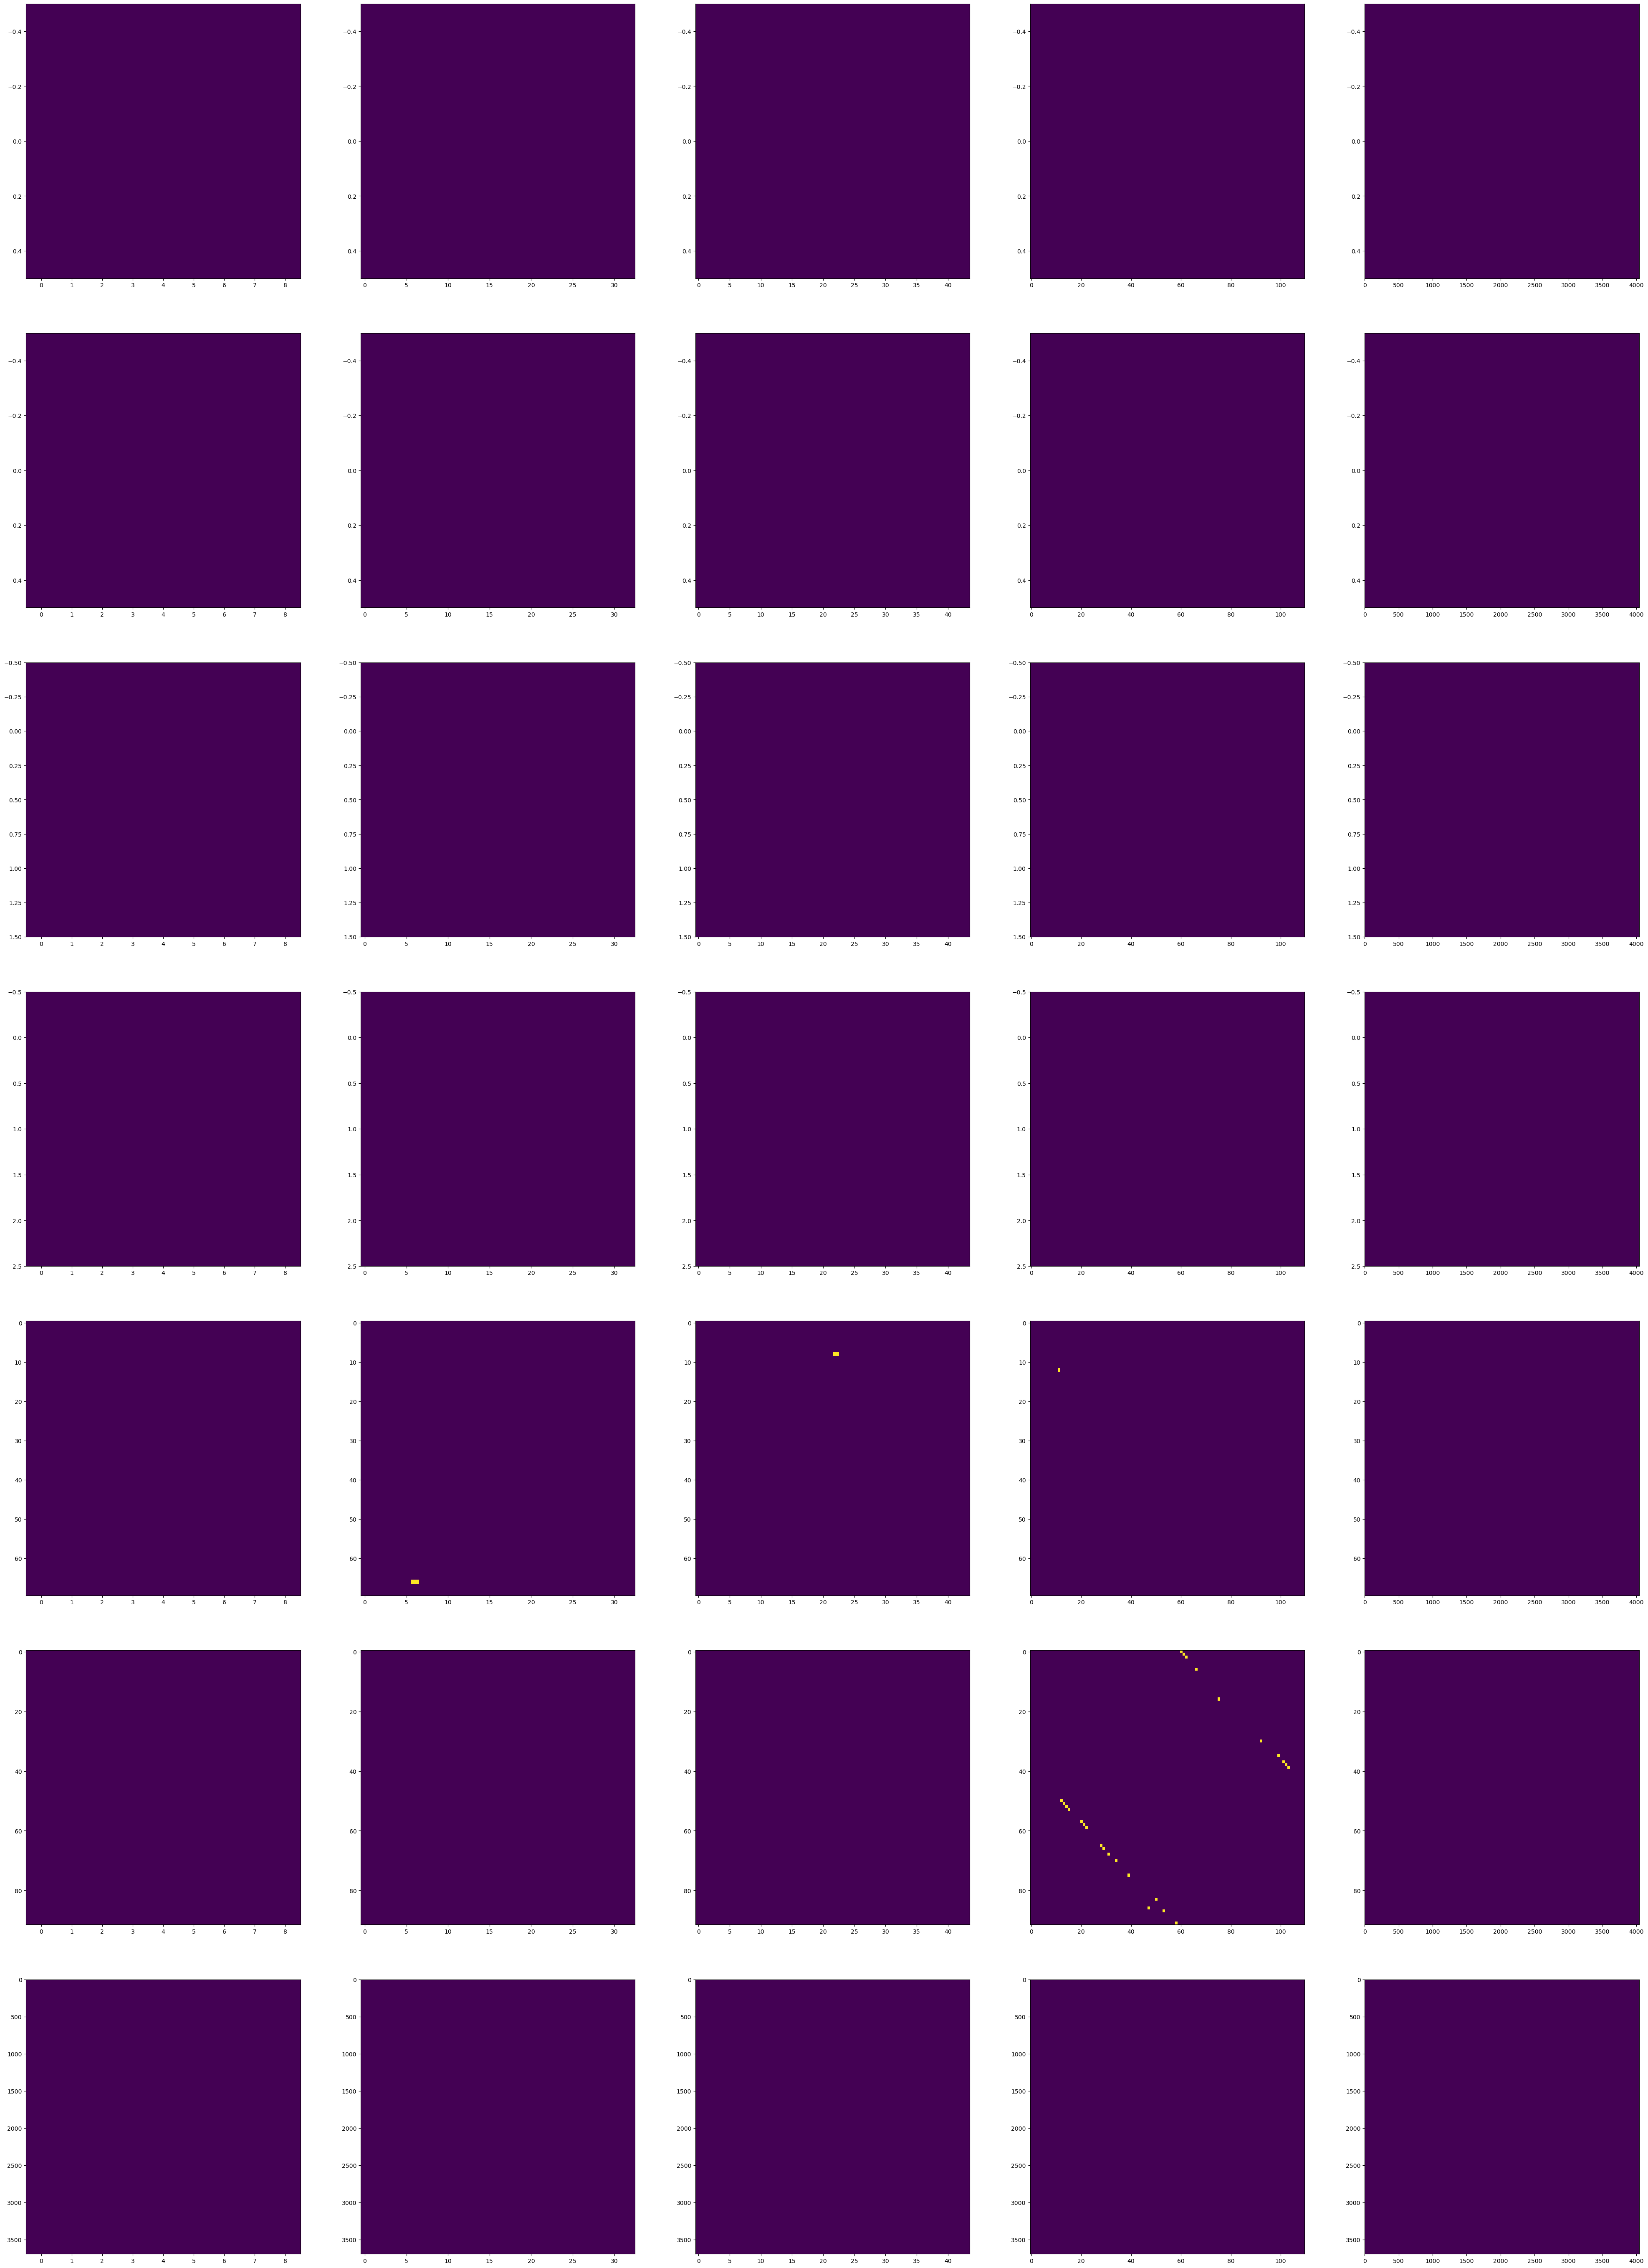

In [55]:
l1,l2 = len(ref_seqs), len(unitigs)
unitigs = sorted(unitigs, key=len)
ref_seqs.sort(key=len)

m = [[] for i in range(l1)]
for i1,u1 in enumerate(ref_seqs):
    s1=u1.num()
    for i2,u2 in enumerate(unitigs):
        s2 = u2.num()
        mi = []
        for _ in range(2):
            mi.append(np.zeros((len(s1),len(s2))))
            for i, ei in enumerate(s1):
                for j, ej in enumerate(s2):
                    if ei==ej:
                        mi[-1][i,j]=1
        mi = max(mi, key=lambda x: x.sum())
        m[i1].append(mi)
fig, axs = plt.subplots(l1,l2, figsize=(l2*10,l1*10))
for i in range(len(m)):
    for j in range(len(m[i])):
        axs[i,j].imshow(m[i][j], interpolation ="none")
        axs[i,j].set_aspect(m[i][j].shape[1]/m[i][j].shape[0])

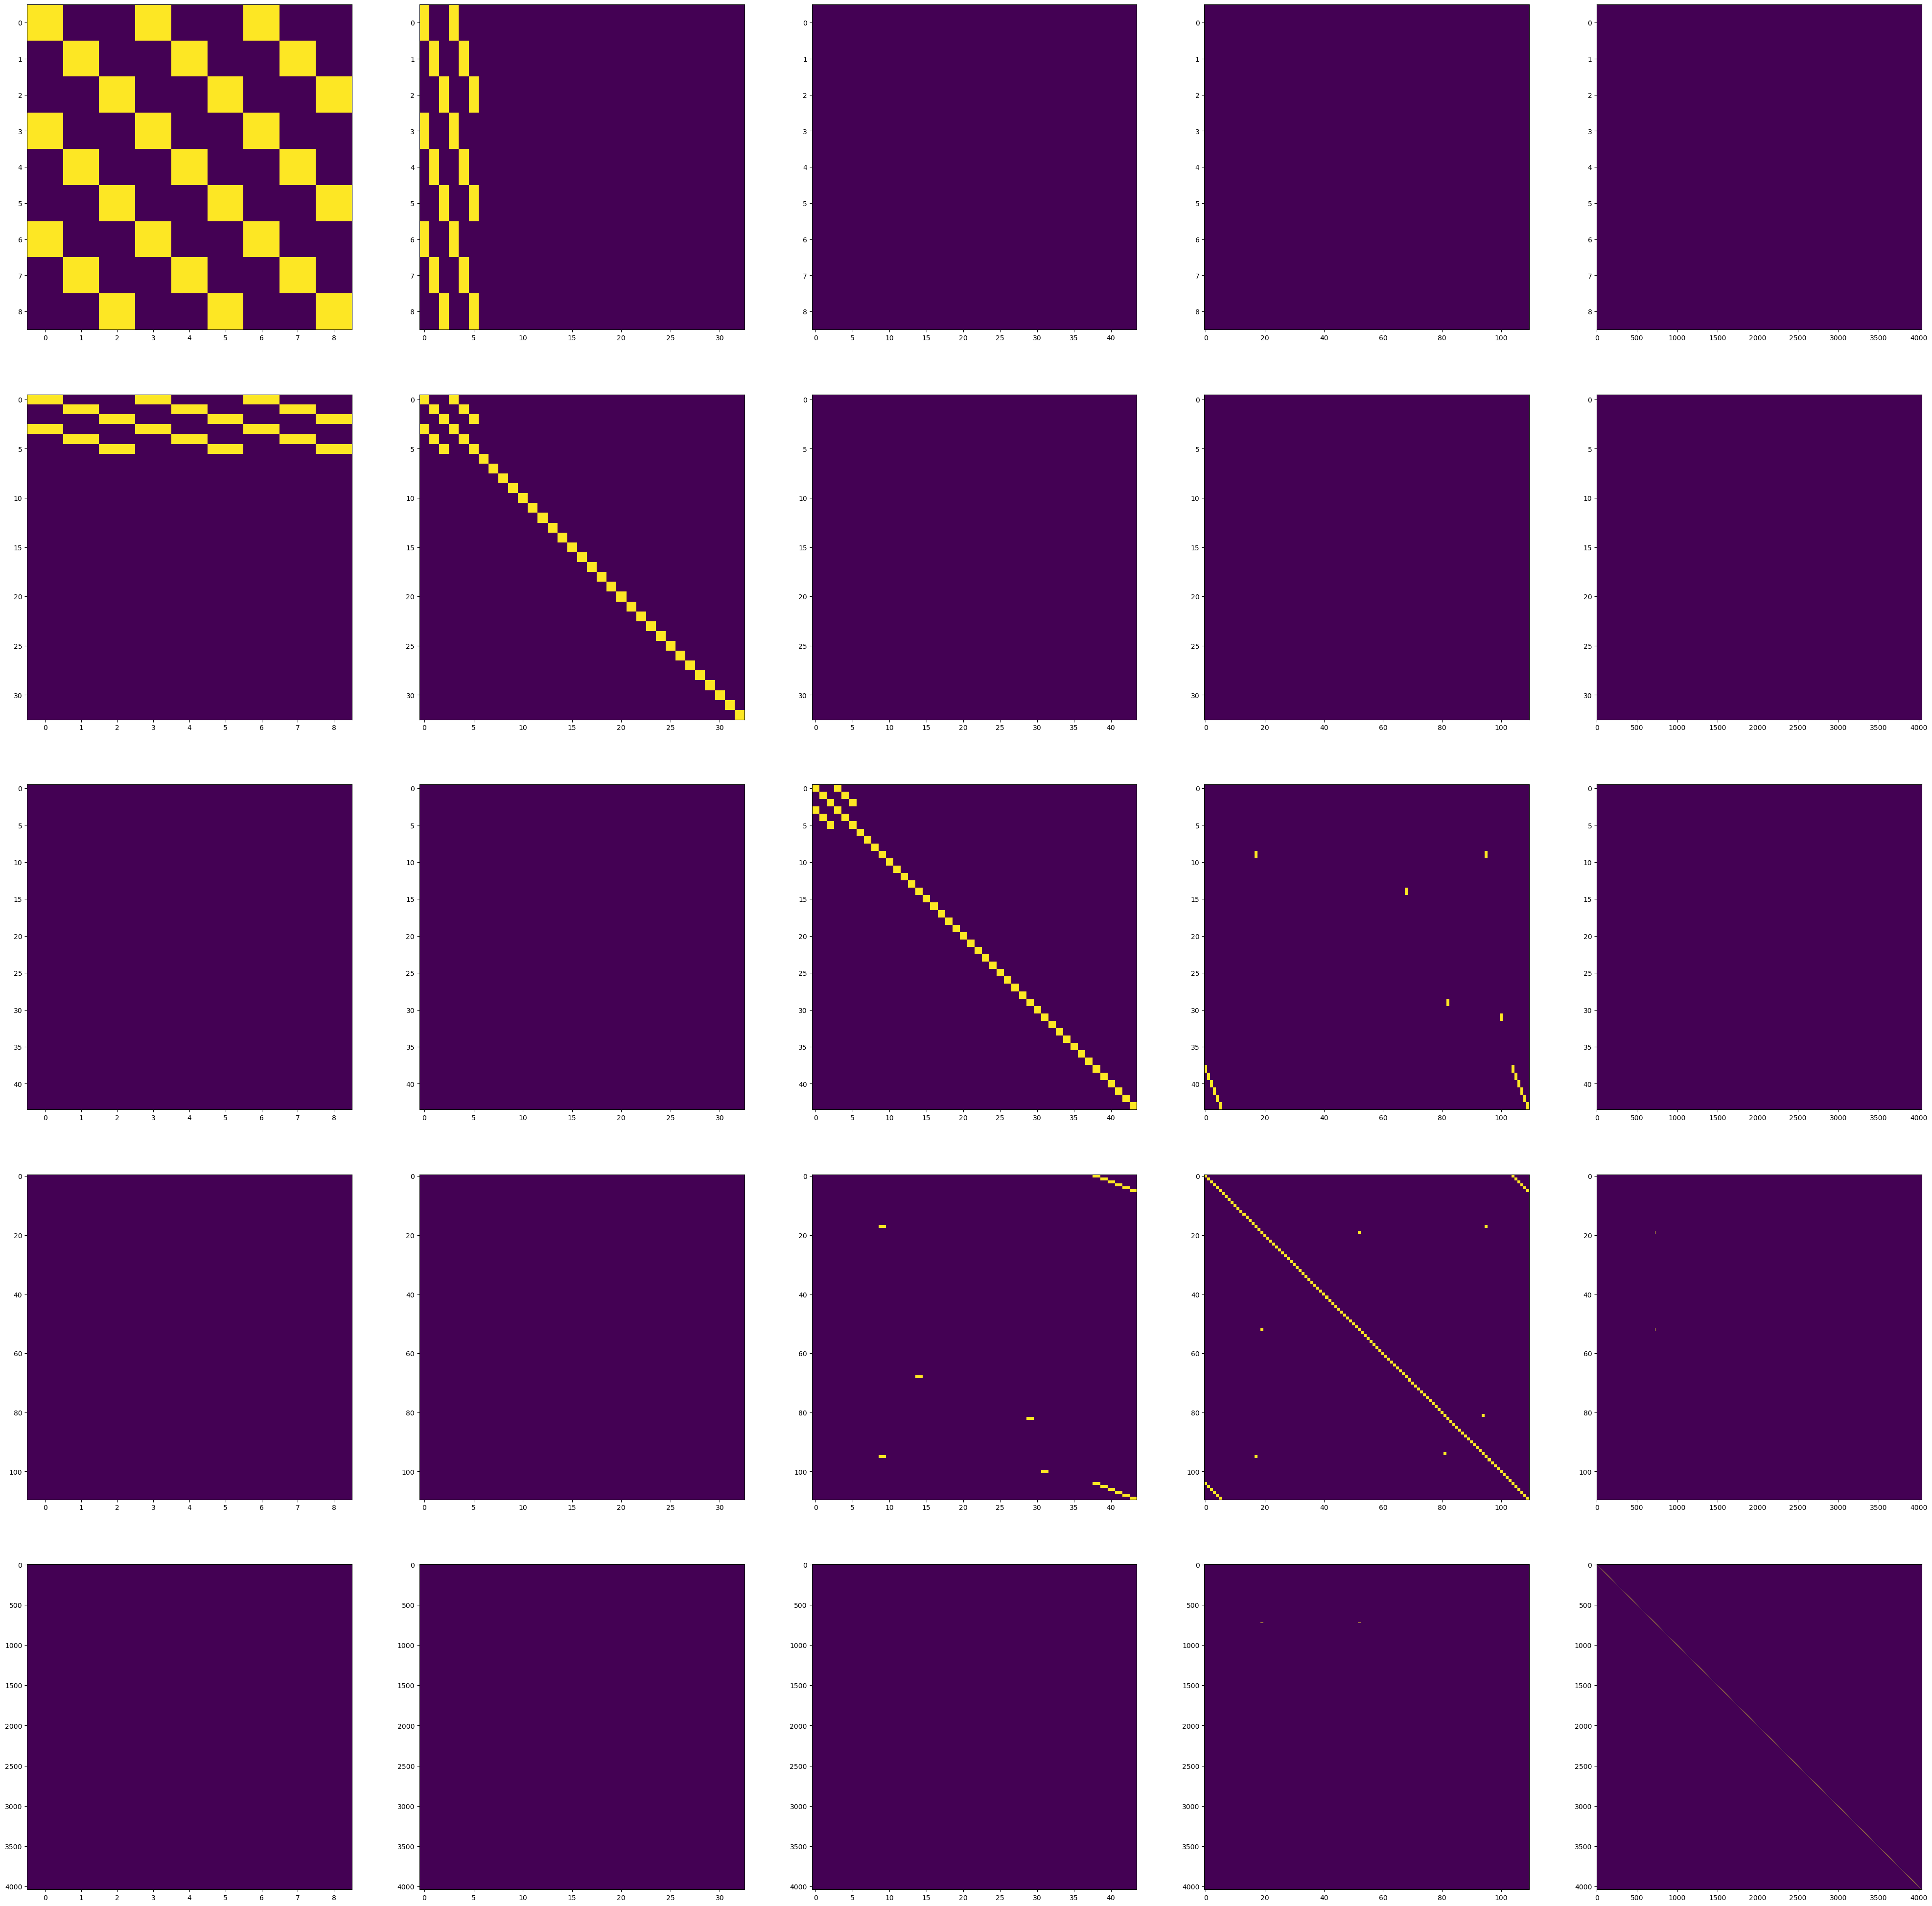

In [56]:
l1,l2 = len(unitigs), len(unitigs)
# unitigs = sorted(unitigs, key=len)
# ref_seqs.sort(key=len)

m = [[] for i in range(l1)]
for i1,u1 in enumerate(unitigs):
    s1=u1.num()
    for i2,u2 in enumerate(unitigs):
        s2 = u2.num()
        mi = []
        for _ in range(2):
            mi.append(np.zeros((len(s1),len(s2))))
            for i, ei in enumerate(s1):
                for j, ej in enumerate(s2):
                    if ei==ej:
                        mi[-1][i,j]=1
        mi = max(mi, key=lambda x: x.sum())
        m[i1].append(mi)
fig, axs = plt.subplots(l1,l2, figsize=(l2*10,l1*10))
for i in range(len(m)):
    for j in range(len(m[i])):
        axs[i,j].imshow(m[i][j], interpolation ="none")
        axs[i,j].set_aspect(m[i][j].shape[1]/m[i][j].shape[0])

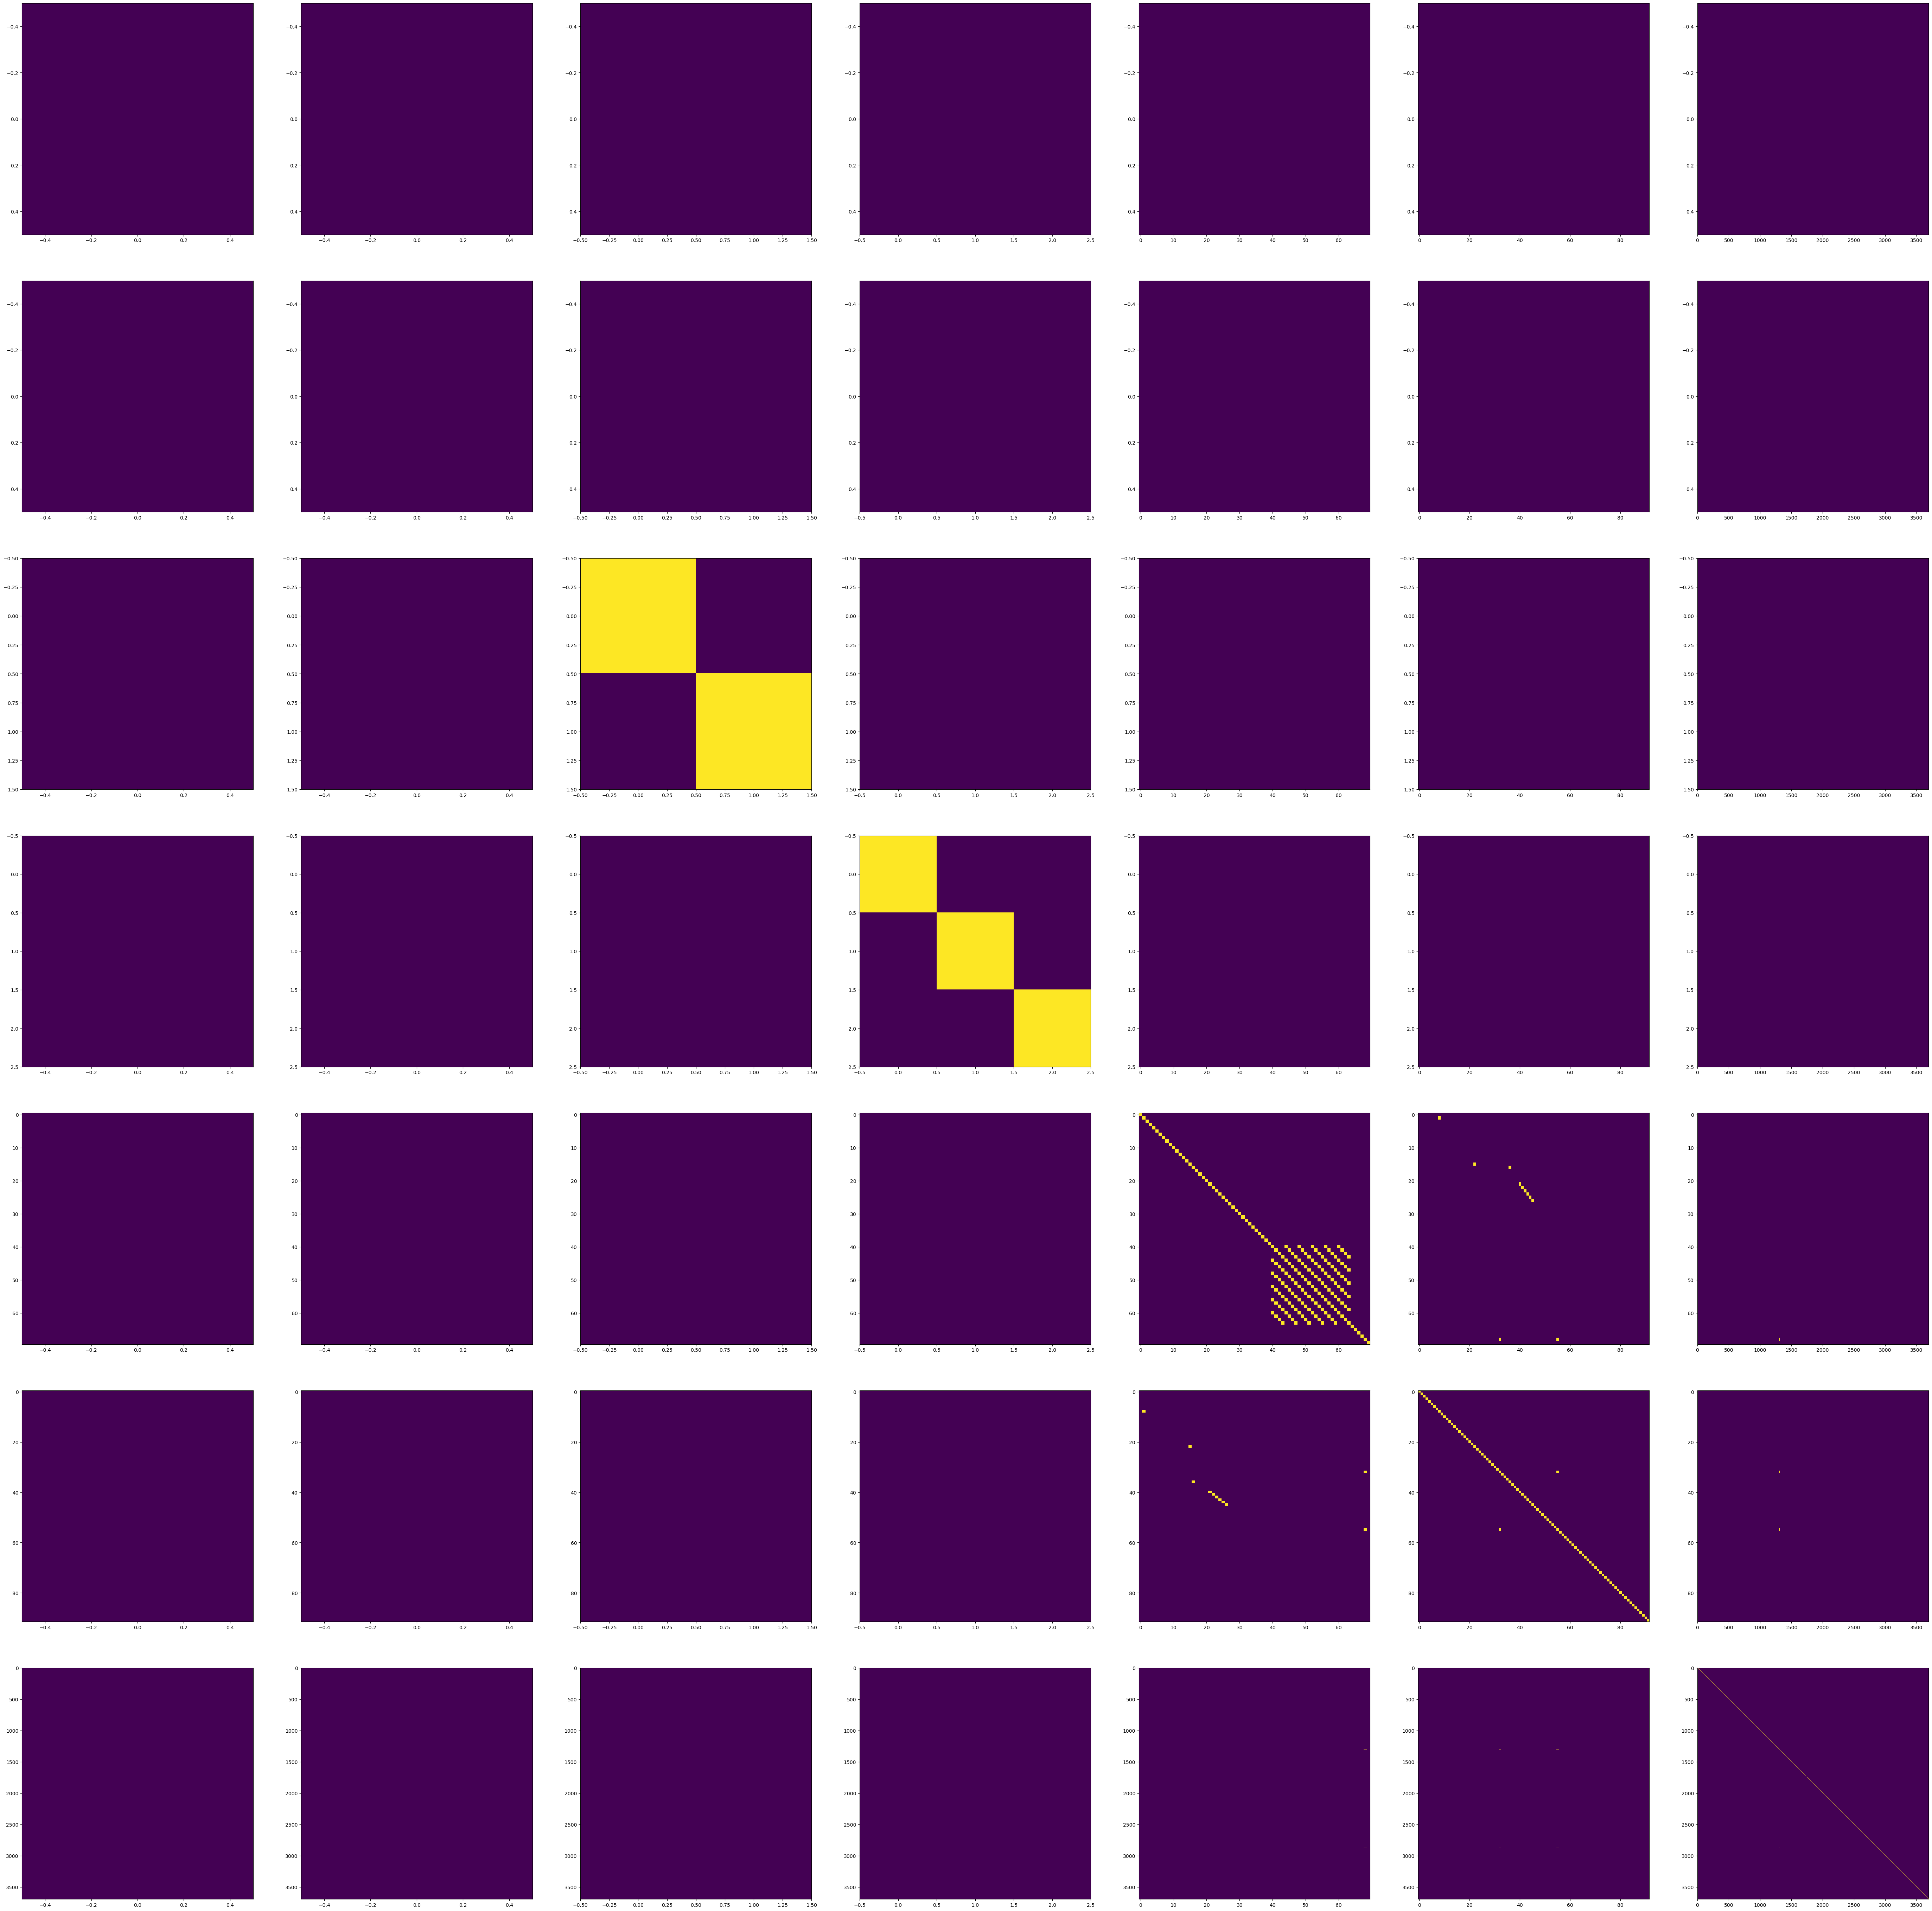

In [57]:
l1,l2 = len(ref_seqs), len(ref_seqs)
# unitigs = sorted(unitigs, key=len)
# ref_seqs.sort(key=len)

m = [[] for i in range(l1)]
for i1,u1 in enumerate(ref_seqs):
    s1=u1.num()
    for i2,u2 in enumerate(ref_seqs):
        s2 = u2.num()
        mi = []
        for _ in range(2):
            mi.append(np.zeros((len(s1),len(s2))))
            for i, ei in enumerate(s1):
                for j, ej in enumerate(s2):
                    if ei==ej:
                        mi[-1][i,j]=1
        mi = max(mi, key=lambda x: x.sum())
        m[i1].append(mi)
fig, axs = plt.subplots(l1,l2, figsize=(l2*10,l1*10))
for i in range(len(m)):
    for j in range(len(m[i])):
        axs[i,j].imshow(m[i][j], interpolation ="none")
        axs[i,j].set_aspect(m[i][j].shape[1]/m[i][j].shape[0])

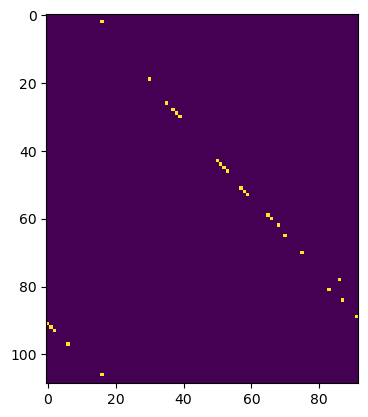

In [500]:
plt.imshow(m)

In [490]:
len(s2)

92

In [491]:
print(m.sum())

0.0


In [492]:
bi_alphabet[1]["+mcmM"]

2568

In [496]:
sum([ss== -2568 for ss in s1])

1

In [61]:
ref_seqs[4].__str__()

'+group_4453~~~+group_5124~~~-group_5233~~~+group_3631~~~+group_3632~~~+group_3633~~~-group_3634~~~-group_4779~~~-korC~~~-group_3034~~~-group_3033~~~+group_5151~~~+group_5150~~~+group_5230~~~+group_5229~~~-group_5124~~~+group_5152~~~-group_805~~~-group_806~~~+parM~~~-group_5110~~~+group_5111~~~+group_5112~~~+group_5128~~~+group_5129~~~+group_5113~~~+group_5114~~~+group_3636~~~+spo0J.parB~~~+psiB~~~+group_727~~~+ardA~~~+pndC~~~+ydfB~~~-group_4892~~~+group_4893~~~-group_4894~~~-trbC~~~-trbB~~~-group_4748~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.

In [87]:
l={}
for r in ref_seqs[:4]:
    for k in r.num():
        l[abs(k)]=[]


In [88]:
l

{1932: [], 1927: [], 1923: [], 1924: [], 1919: [], 1920: [], 1918: []}

In [104]:
for i, s in enumerate(subseq):
    for k in s.num():
        if abs(k) in l:
            l[abs(k)].append(i)
            if len(s)<5:
                print(str(s))


+group_116~~~+group_5281
-group_5274~~~+acrA~~~+acrB


In [97]:
[(k,len(lm)) for k,lm in l.items()]

[(1932, 95),
 (1927, 0),
 (1923, 78),
 (1924, 0),
 (1919, 94),
 (1920, 0),
 (1918, 94)]

In [100]:
for r in ref_seqs[:4]:
    print(r.num(), str(r))

[1932] +group_5299
[1927] +group_5288
[1923 1924] +group_5281~~~+group_5282
[ 1919 -1920  1918] +group_5277~~~-group_5278~~~+group_5274
